# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [0]:
 # Basic imports.
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [2]:
# Setting predefined arguments.
args = {
    'epoch_num': 100,     # Number of epochs.
    'lr': 1e-4,           # Learning rate.
    'weight_decay': 5e-5, # L2 penalty.
    'num_workers': 8,     # Number of workers on data loader.
    'batch_size': 100,    # Mini-batch size.
    'print_freq': 1,      # Printing frequency.
    'z_dim': 50,          # Dimension of z input vector.
    'num_samples': 4,     # Number of samples to be generated in evaluation.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Carregando o  MNIST

In [3]:
# Root directory for the dataset (to be downloaded).
root = './'

# Transformations over the dataset.
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Setting datasets and dataloaders.
train_set = datasets.MNIST(root,
                           train=True,
                           download=True,
                           transform=data_transforms)
test_set = datasets.MNIST(root,
                          train=False,
                          download=False,
                          transform=data_transforms)

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

# Printing training and testing dataset sizes.
print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

0it [00:00, ?it/s]

9920512it [00:02, 4454345.79it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 67824.03it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 1148149.13it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 26080.05it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
Size of training set: 60000 samples
Size of test set: 10000 samples


# Treinamento Adversarial


Entre 2012 e 2014, foi percebido que os modelos tradicionais usados para reconhecimento de imagens com redes profundas, como a AlexNet, eram suscetíveis a **Ataques Adversariais** que faziam com que elas errassem grosseiramente sua classificação com alterações imperceptíveis para humanos na amostra de teste. Daí surgiu a ideia de incorporar esses ataques adversariais ao processo de treino, dando origem às [Generative Adversarial Networks](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) (GANs) clássicas.

O treinamento de GANs , ao contrário das redes que temos visto no curso até o momento, é um procedimento um pouco mais complexo. Não queremos mais treinar apenas uma rede, mas sim um par de redes: uma Generativa ($G$) e uma Discriminativa ($D$). A ideia é que essas redes vão competir pelo mesmo objetivo num cenário categorizado pela **Teoria dos Jogos** de **Adversarial**. GANs corretamente treinadas possuem a propriedade de "arriscar" mais na geração de suas amostras que simples redes de regressão para síntese de amostras ou modelos não-supervisionados como AEs tradicionais e até VAEs, podendo vir a produzir imagens mais realistas, mas também arriscando cometer erros mais grosseiros (i.e. **halucinações** de objetos que não deveriam estar na cena).

Ainda assim, o processo de treinamento de uma GAN é considerado consideravelmente difícil, já que o "balanço" entre as losses (ou o [Equilíbrio de Nash](https://en.wikipedia.org/wiki/Nash_equilibrium) no linguajar de **Teoria dos Jogos**) deve ser mantido ao longo do treinamento das redes. Vários problemas surgiram nas primeiras gerações de GANs, incluindo:

*   Losses Instáveis; ![Losses in GANs](https://www.dropbox.com/s/f16potfm95ofagz/gan_losses.png?dl=1)

*   Mode Collapse; ![Mode Collapse](https://www.dropbox.com/s/xcd5j4nybadrnnw/mode_collapse.png?dl=1)

*   Diminuição  do Gradiente de $D$. ![Diminishing Gradient](https://miro.medium.com/max/700/1*k7g4Pu1ujz439p0f67BNyQ.jpeg)

Duas referências interessantes sobre os porquês de ser complicado treinar GANs são:
*    https://arxiv.org/abs/1606.03498
*    https://medium.com/@jonathan_hui/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b

O fluxo de dados do treinamento de uma GAN tradicional pode ser exemplificado na seguinte animação:

![GAN Training](https://www.dropbox.com/s/jxr3fgg4mcl6mon/GAN.gif?dl=1)

A ideia é que $G$ e $D$ tenham losses opostas, permitindo que elas compitam por objetivos opostos. O objetivo de $D$ é discernir sempre entre amostras falsas vindas de $G$ e imagens reais dos dados de treino, enquanto $G$ quer aprender a gerar cada vez mais imagens verossímeis para enganar $D$. Em teoria, o processo de treinamento é finalizado quando $D$ obtém acurácia de 50%, não sabendo mais diferenciar entre amostras reais e falsas, porém isso muito raramente acontece na prática.

# Definindo o Gerador $G$

In [4]:
# Adversarial Generator.
class Generator(nn.Module):
    
    def __init__(self, input_dim=100):
    
        super(Generator, self).__init__()
        
        self.input_dim = input_dim

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 196),
            nn.BatchNorm1d(196),
            nn.ReLU(),
            nn.Linear(196, 392),
            nn.BatchNorm1d(392),
            nn.ReLU(),
            nn.Linear(392, 784),
            nn.Sigmoid(),
        )
        
        self.initialize_weights()

        
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        
        x = self.fc(x)

        return x

# Instantiating G.
net_G = Generator(input_dim=args['z_dim']).to(args['device'])

# Printing architecture.
print(net_G)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=50, out_features=196, bias=True)
    (1): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=196, out_features=392, bias=True)
    (4): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=392, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


# Definindo o Discriminador $D$

In [5]:
# Adversarial Discriminator.
class Discriminator(nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(784, 392),
            nn.BatchNorm1d(392),
            nn.LeakyReLU(0.2),
            nn.Linear(392, 196),
            nn.BatchNorm1d(196),
            nn.LeakyReLU(0.2),
            nn.Linear(196, 1),
#             nn.Sigmoid(),
        )
        
        self.initialize_weights()

        
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
                
    def forward(self, x):
        
        x = self.fc(x)

        return x

# Instantiating D.
net_D = Discriminator().to(args['device'])

# Printing architecture.
print(net_D)

Discriminator(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=392, out_features=196, bias=True)
    (4): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=196, out_features=1, bias=True)
  )
)


# Definindo o otimizadores

In [0]:
# TO DO: defining optimizer for G.
opt_G = optim.Adam(net_G.parameters(),
                   lr=args['lr'],
                   weight_decay=args['weight_decay'])

# TO DO: defining optimizer for D.
opt_D = optim.Adam(net_D.parameters(),
                   lr=args['lr'],
                   weight_decay=args['weight_decay'])

# Definindo um Scheduler para os Learning Rates

In [0]:
# TO DO: defining lr scheduler.
scheduler_G = optim.lr_scheduler.StepLR(opt_G, args['epoch_num'] // 5, 0.5)
scheduler_D = optim.lr_scheduler.StepLR(opt_D, args['epoch_num'] // 5, 0.5)

# Definindo a loss composta

In [0]:
# TO DO: defining adversarial loss.
# criterion = nn.BCELoss().to(args['device'])
criterion = nn.MSELoss().to(args['device'])

# Criando funções para Treino e Teste

In [0]:
# Training procedure.
def train(train_loader,
          net_G, net_D,
          criterion,
          opt_G, opt_D,
          epoch,
          train_loss_G, train_loss_D):
    
    tic = time.time()
    
    # Predefining ones and zeros for batches.
    y_real = torch.ones(args['batch_size'], 1).to(args['device'])
    y_fake = torch.zeros(args['batch_size'], 1).to(args['device'])

    # Setting networks for training mode.
    net_D.train()
    net_G.train()
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):
        
        # Obtaining images and labels for batch.
        x, labs = batch_data
        
        x = x.view(x.size(0), -1)
        
        # TO DO: Creating random vector z.
        z = torch.rand((args['batch_size'], args['z_dim']))
        
        # TO DO: Casting to correct device (x and z).
        x = x.to(args['device'])
        z = z.to(args['device'])
        
        ###############
        # Updating D. #
        ###############
        
        # TO DO: Clearing the gradients of D optimizer.
        opt_D.zero_grad()

        # TO DO: Forwarding real data.
        D_real = net_D(x) # Through D.
        
        # TO DO: Computing loss for real data.
        D_real_loss = criterion(D_real, y_real)

        # TO DO: Forwarding fake data.
        G_out = net_G(z) # Through G.
        
        D_fake = net_D(G_out) # Through D.
        
        # TO DO: Computing loss for fake data.
        D_fake_loss = criterion(D_fake, y_fake)

        # TO DO: Computing total loss for D.
        D_loss = D_real_loss + D_fake_loss
        
        # TO DO: Computing backpropagation for D.
        D_loss.backward()
        
        # TO DO: Taking step in D optimizer.
        opt_D.step()

        ###############
        # Updating G. #
        ###############
        
        # TO DO: Clearing the gradients of G optimizer.
        opt_G.zero_grad()

        # TO DO: Forwarding fake data.
        G_out = net_G(z) # Through G.
        
        D_fake = net_D(G_out) # Through D.
        
        # TO DO: Computing loss for G.
        G_loss = criterion(D_fake, y_real)
        
        # TO DO: Computing backpropagation for G.
        G_loss.backward()
        
        # TO DO: Taking step in G optimizer.
        opt_G.step()
        
        
        # Updating lists.
        train_loss_G.append(G_loss.data.item())
        train_loss_D.append(D_loss.data.item())

    toc = time.time()
    
    # Printing training epoch loss.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [training time %.2f]' % (
        epoch, (toc - tic)))
    print('-------------------------------------------------------------------')
    
    if epoch % args['print_freq'] == 0:
        
        # Plotting losses.
        fig, ax = plt.subplots(1, 2, figsize=(16, 4))

        ax[0].plot(np.asarray(train_loss_G), 'r-', label='G loss')
        ax[0].legend()
        
        ax[1].plot(np.asarray(train_loss_D), 'b--', label='D loss')
        ax[1].legend()

        plt.show()
        
    return train_loss_G, train_loss_D

In [0]:
# Evaluating procedure.
def evaluate(net_G, criterion, epoch):
    
    # Setting networks for training mode.
    net_D.eval()
    net_G.eval()
    
    # Creating random vector z.
    z = torch.rand((args['num_samples'] * args['num_samples'], args['z_dim']))
    
    # Casting to correct device.
    z = z.to(args['device'])
    
    # Generating new samples.
    G_out = net_G(z)
    
    # Plotting.
    fig, ax = plt.subplots(args['num_samples'],
                           args['num_samples'],
                           figsize=(8, 8))
    
    for i in range(args['num_samples']):
        
        for j in range(args['num_samples']):
            
            sample = G_out[j * args['num_samples'] + i]
            
            ax[j, i].imshow(sample.detach().view(28, 28).cpu().numpy().squeeze(),
                            cmap=plt.get_cmap('gray'))
            ax[j, i].set_yticks([])
            ax[j, i].set_xticks([])
            
    plt.show()

# Iterando sobre epochs

-------------------------------------------------------------------
[epoch 1], [training time 8.02]
-------------------------------------------------------------------


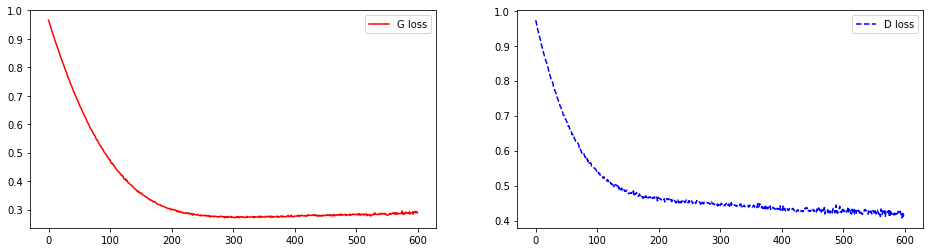

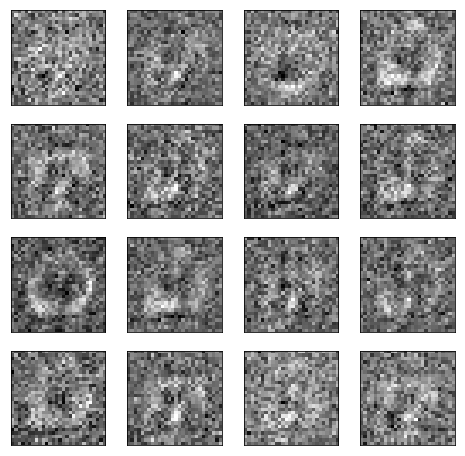

-------------------------------------------------------------------
[epoch 2], [training time 8.61]
-------------------------------------------------------------------


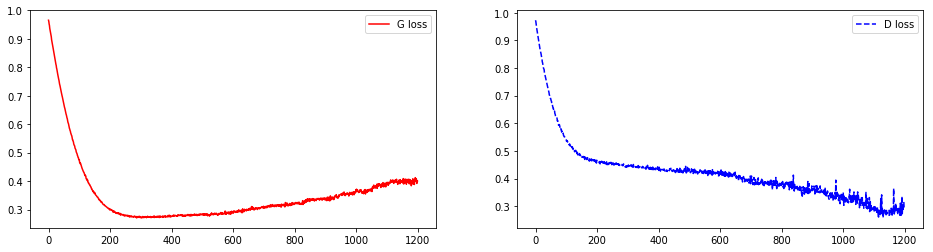

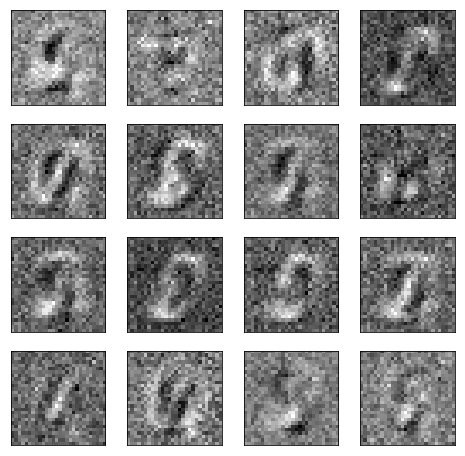

-------------------------------------------------------------------
[epoch 3], [training time 8.63]
-------------------------------------------------------------------


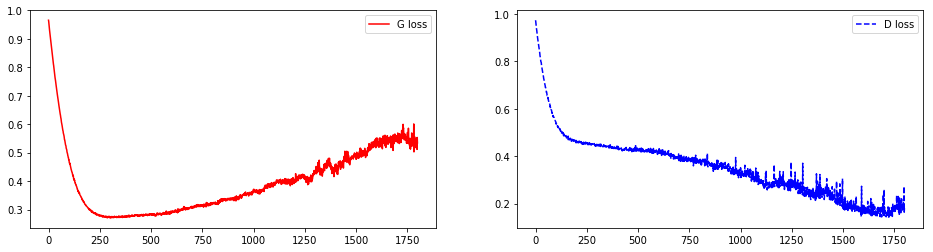

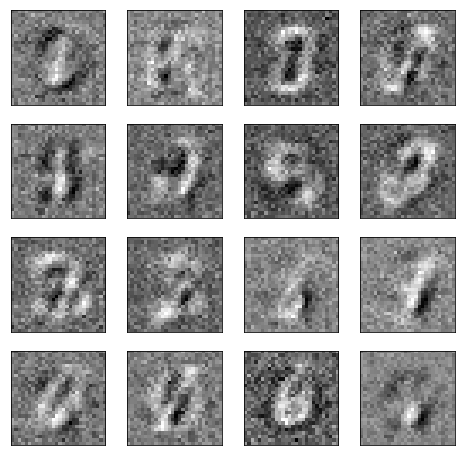

-------------------------------------------------------------------
[epoch 4], [training time 8.64]
-------------------------------------------------------------------


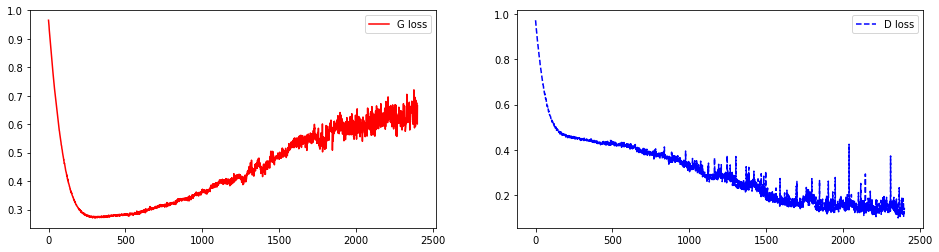

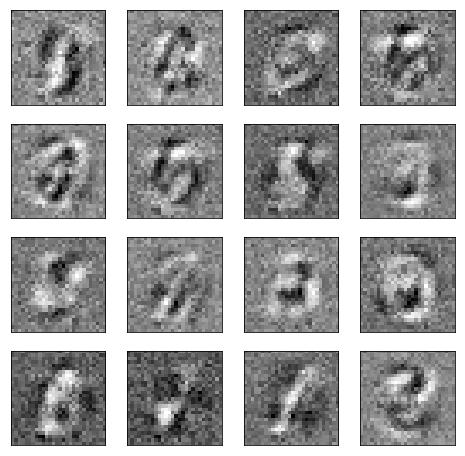

-------------------------------------------------------------------
[epoch 5], [training time 8.70]
-------------------------------------------------------------------


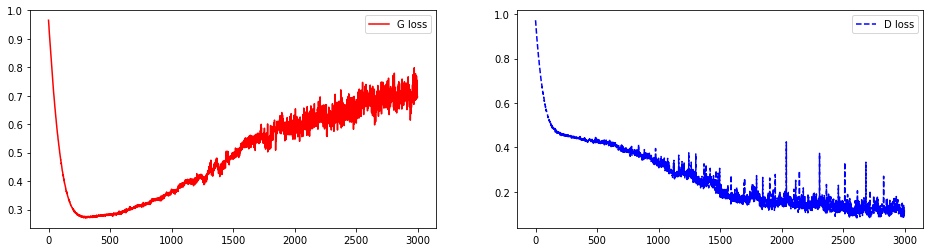

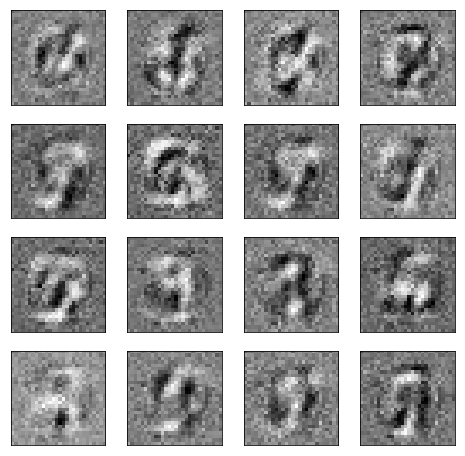

-------------------------------------------------------------------
[epoch 6], [training time 8.75]
-------------------------------------------------------------------


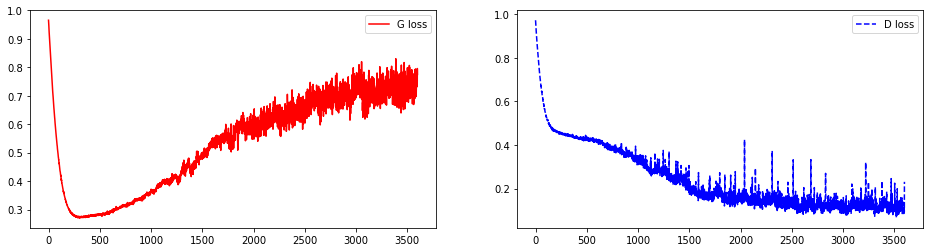

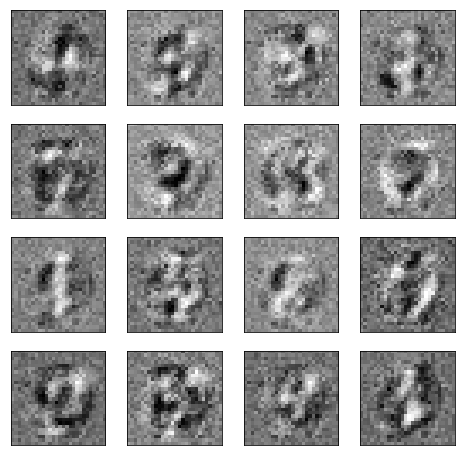

-------------------------------------------------------------------
[epoch 7], [training time 9.95]
-------------------------------------------------------------------


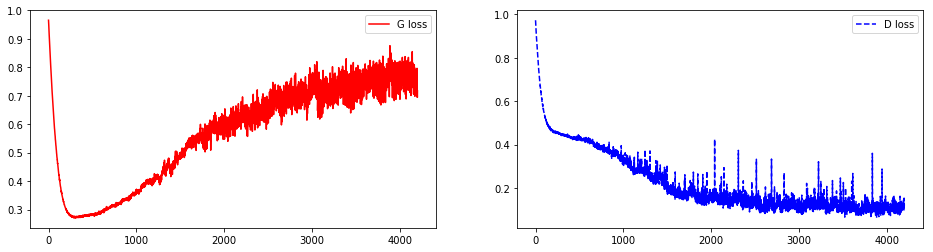

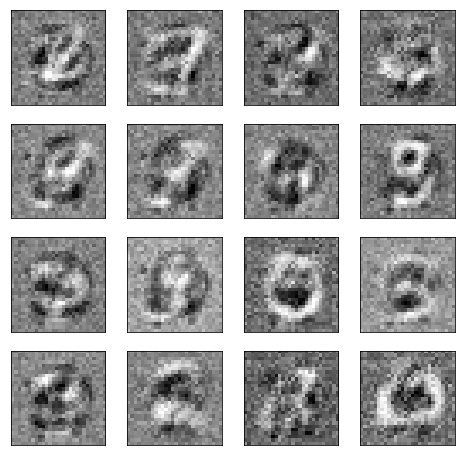

-------------------------------------------------------------------
[epoch 8], [training time 8.74]
-------------------------------------------------------------------


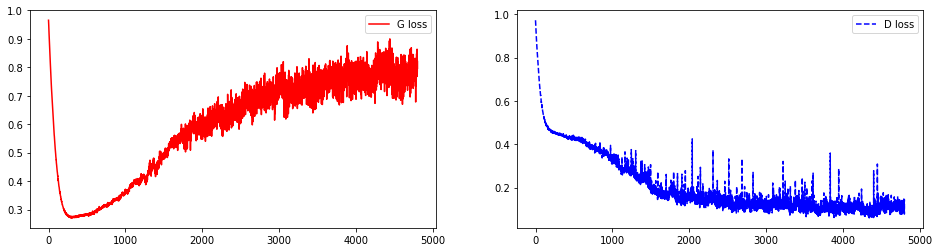

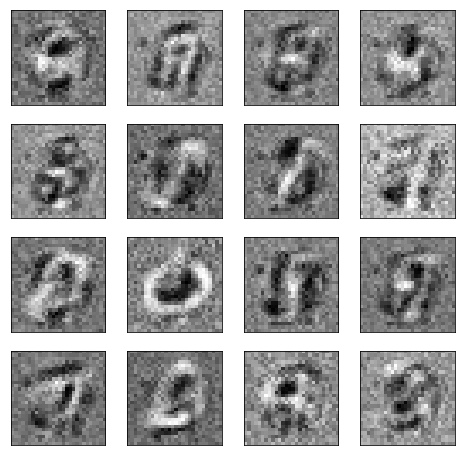

-------------------------------------------------------------------
[epoch 9], [training time 8.77]
-------------------------------------------------------------------


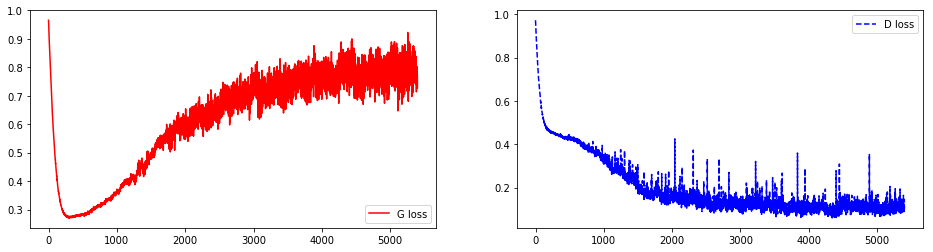

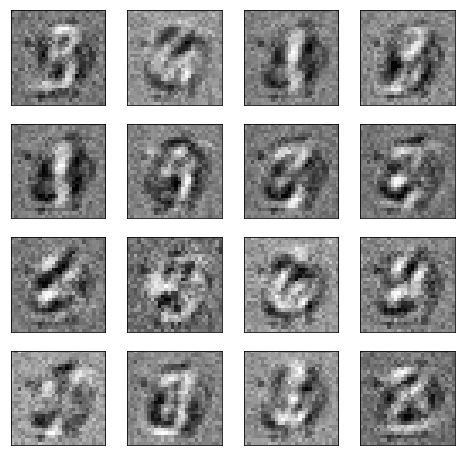

-------------------------------------------------------------------
[epoch 10], [training time 8.74]
-------------------------------------------------------------------


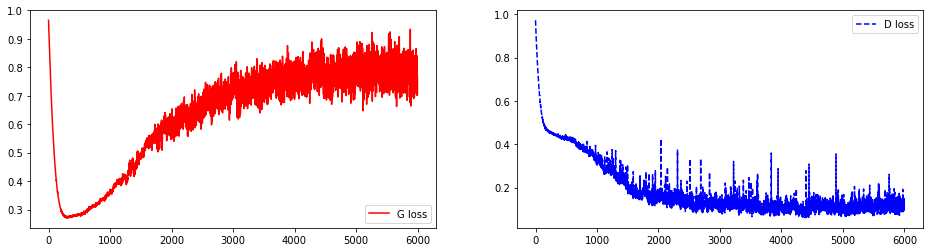

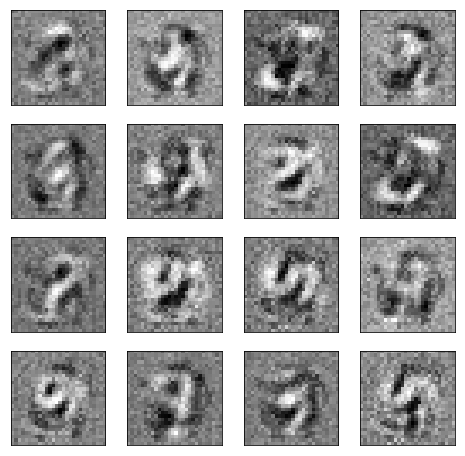

-------------------------------------------------------------------
[epoch 11], [training time 8.74]
-------------------------------------------------------------------


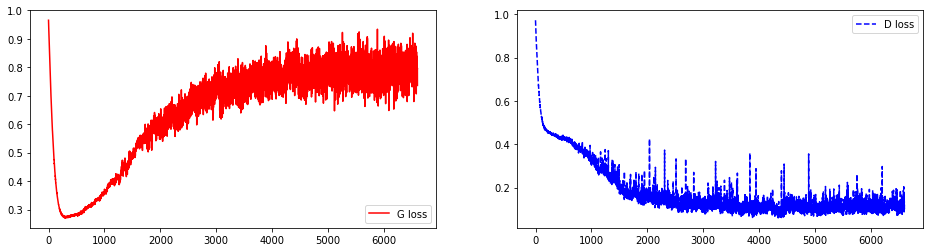

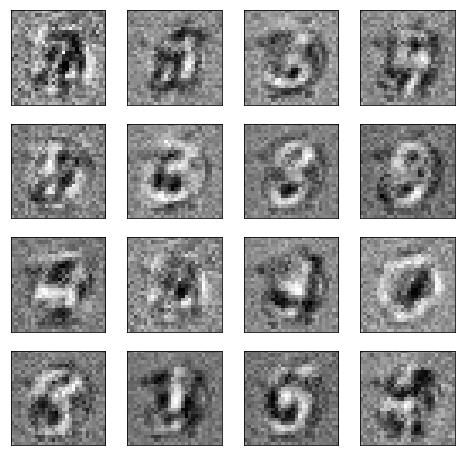

-------------------------------------------------------------------
[epoch 12], [training time 8.78]
-------------------------------------------------------------------


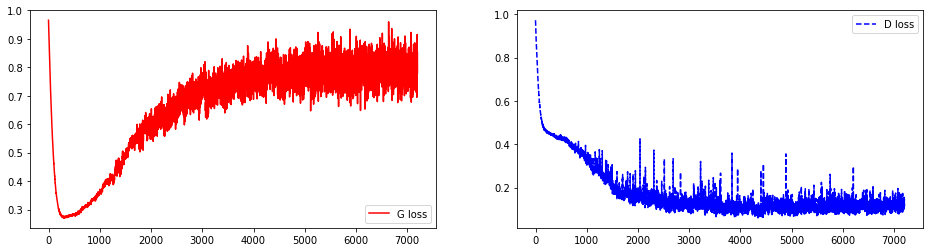

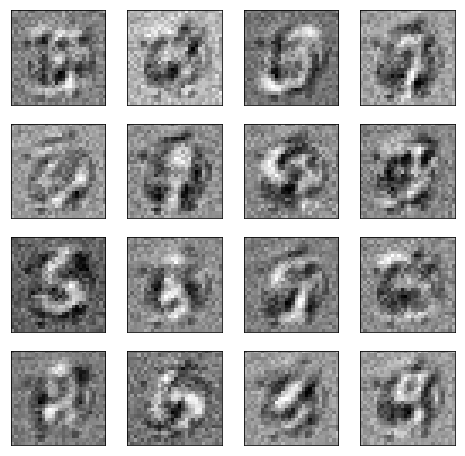

-------------------------------------------------------------------
[epoch 13], [training time 8.82]
-------------------------------------------------------------------


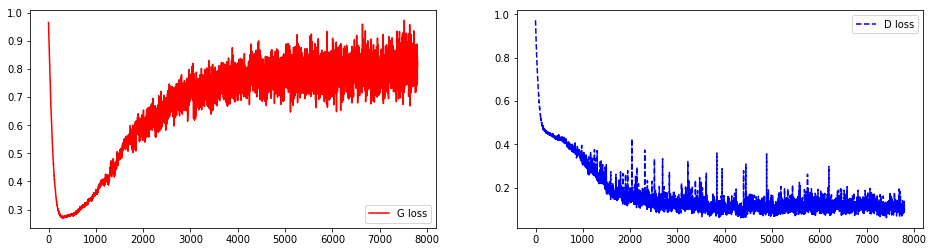

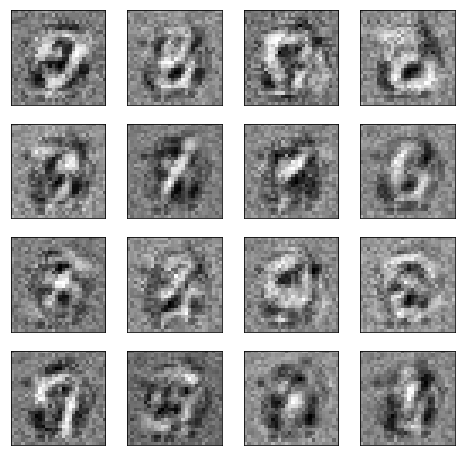

-------------------------------------------------------------------
[epoch 14], [training time 8.84]
-------------------------------------------------------------------


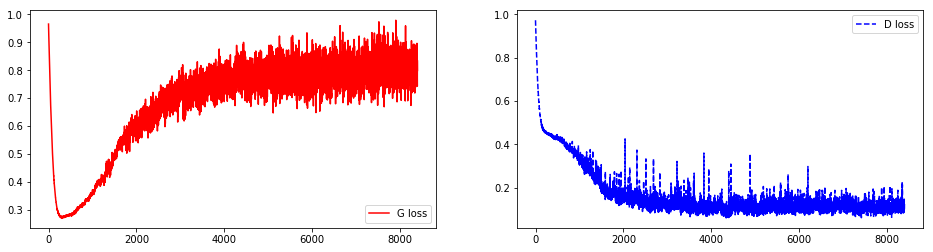

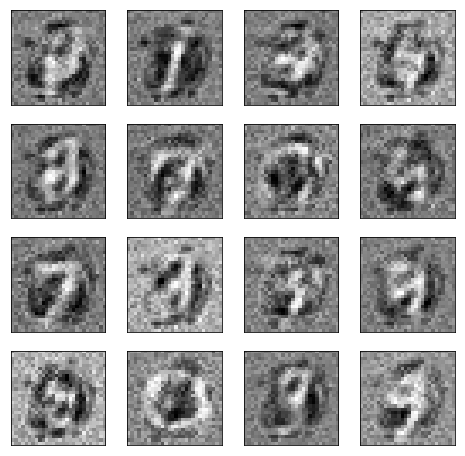

-------------------------------------------------------------------
[epoch 15], [training time 8.77]
-------------------------------------------------------------------


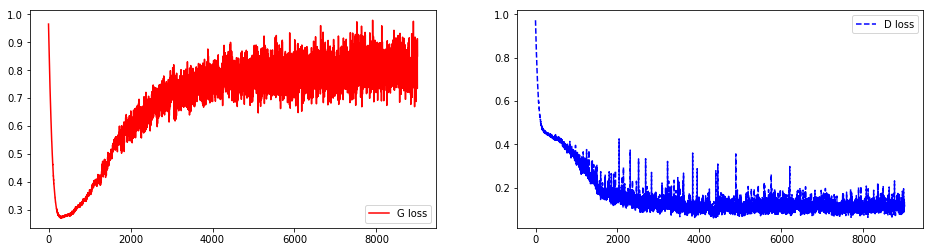

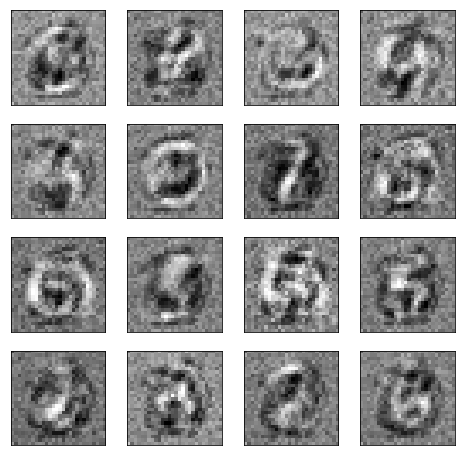

-------------------------------------------------------------------
[epoch 16], [training time 8.77]
-------------------------------------------------------------------


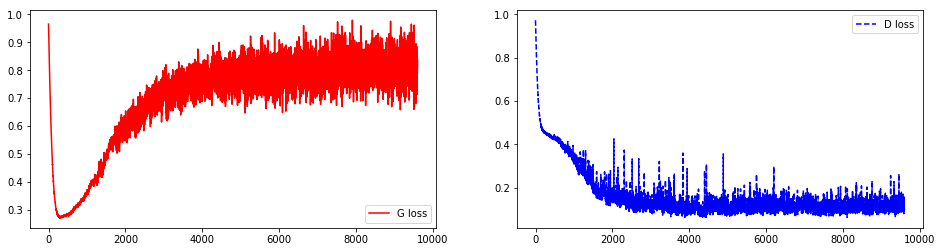

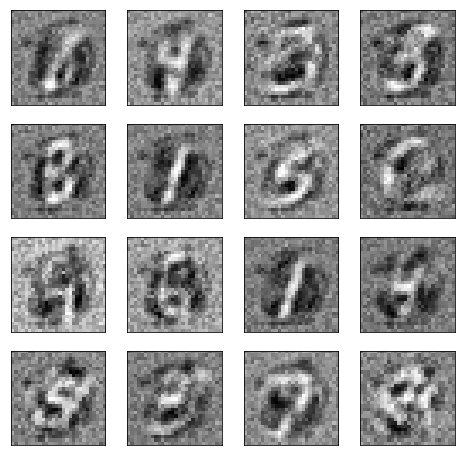

-------------------------------------------------------------------
[epoch 17], [training time 8.77]
-------------------------------------------------------------------


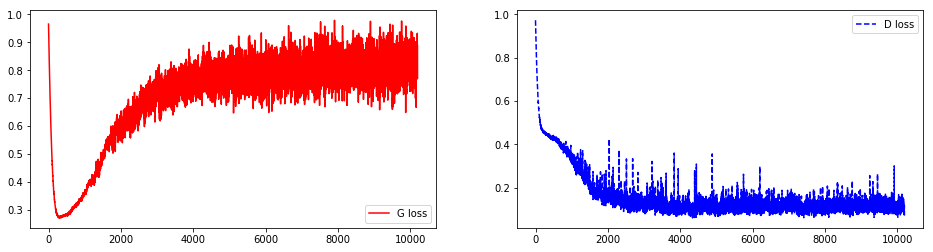

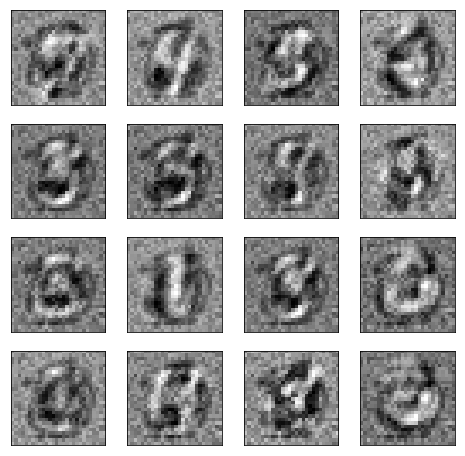

-------------------------------------------------------------------
[epoch 18], [training time 9.79]
-------------------------------------------------------------------


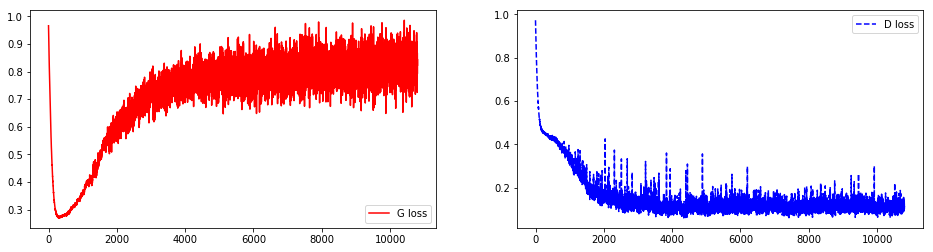

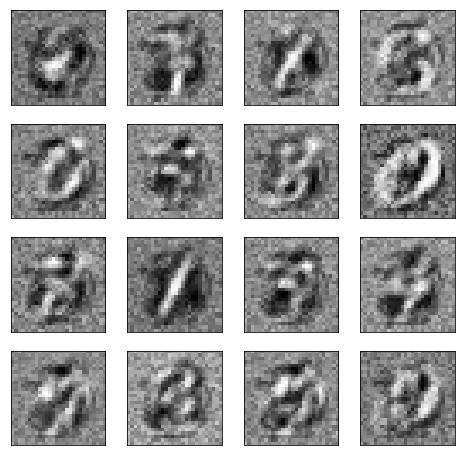

-------------------------------------------------------------------
[epoch 19], [training time 8.78]
-------------------------------------------------------------------


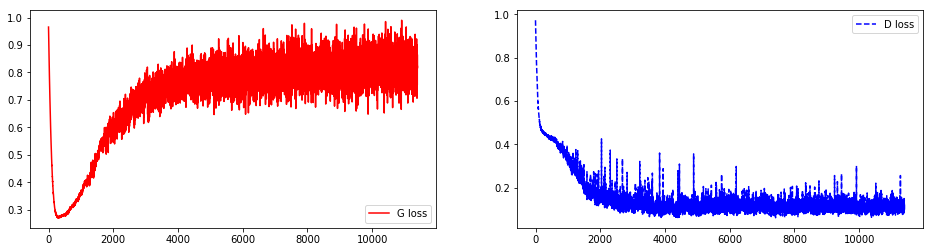

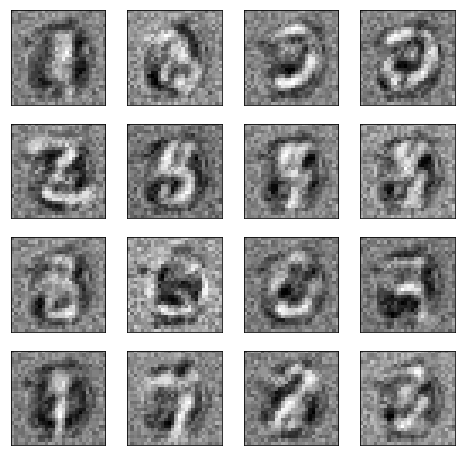

-------------------------------------------------------------------
[epoch 20], [training time 8.77]
-------------------------------------------------------------------


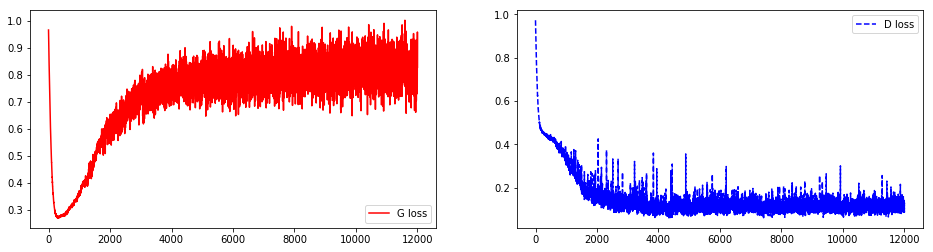

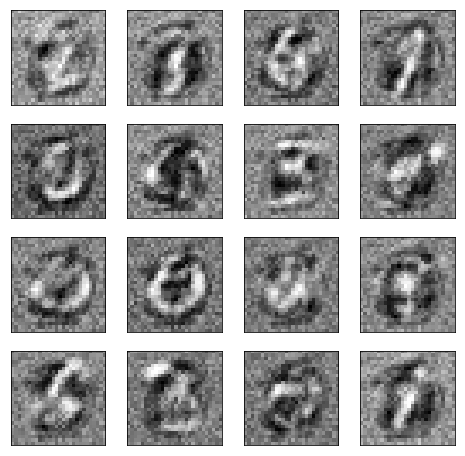

-------------------------------------------------------------------
[epoch 21], [training time 8.79]
-------------------------------------------------------------------


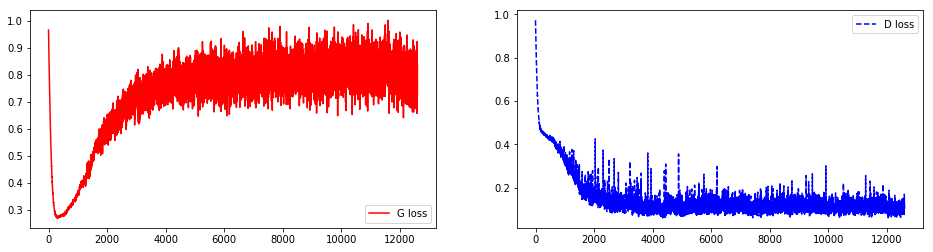

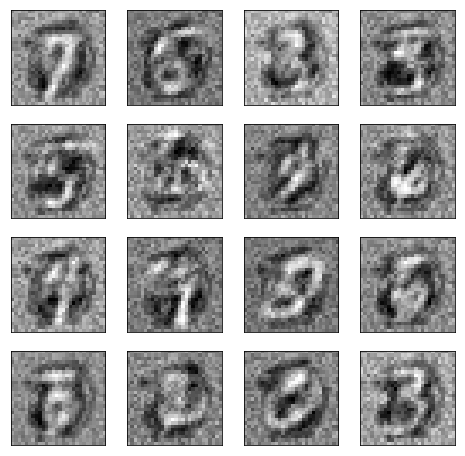

-------------------------------------------------------------------
[epoch 22], [training time 8.81]
-------------------------------------------------------------------


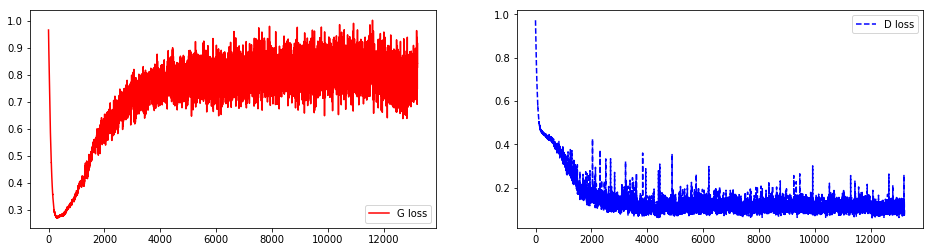

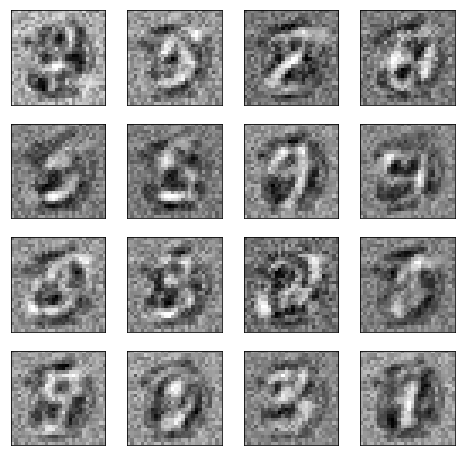

-------------------------------------------------------------------
[epoch 23], [training time 8.73]
-------------------------------------------------------------------


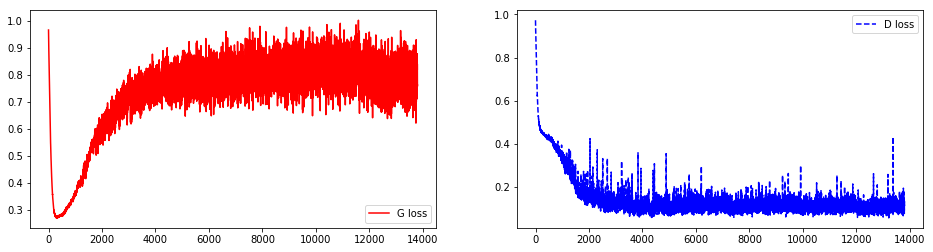

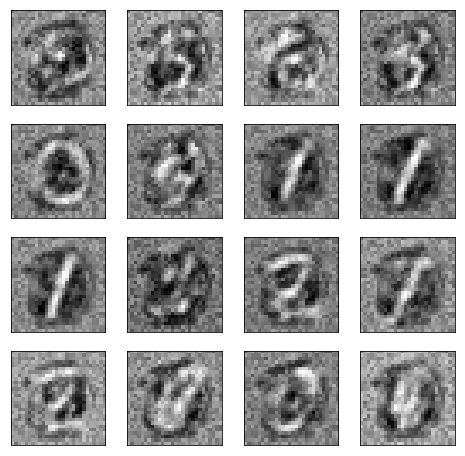

-------------------------------------------------------------------
[epoch 24], [training time 8.82]
-------------------------------------------------------------------


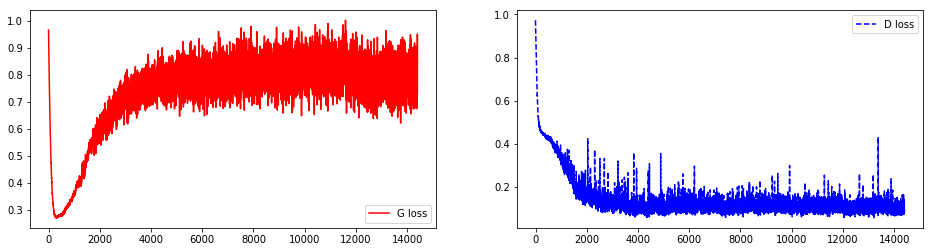

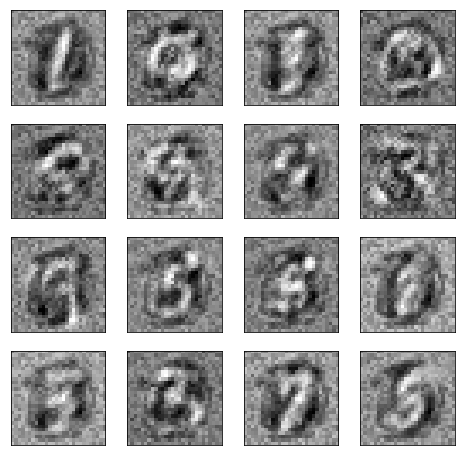

-------------------------------------------------------------------
[epoch 25], [training time 8.83]
-------------------------------------------------------------------


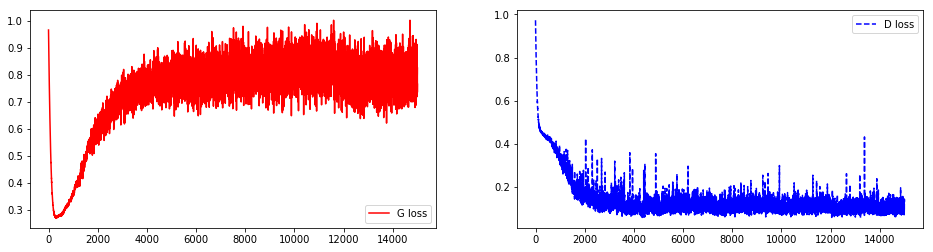

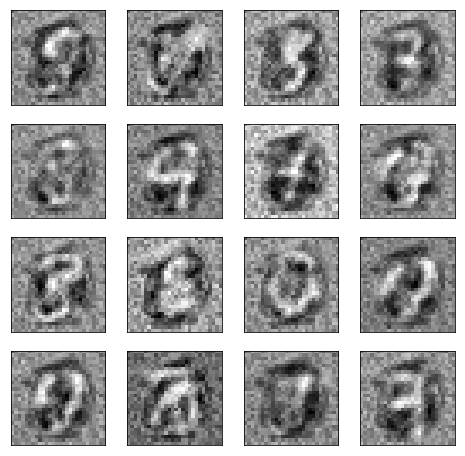

-------------------------------------------------------------------
[epoch 26], [training time 8.76]
-------------------------------------------------------------------


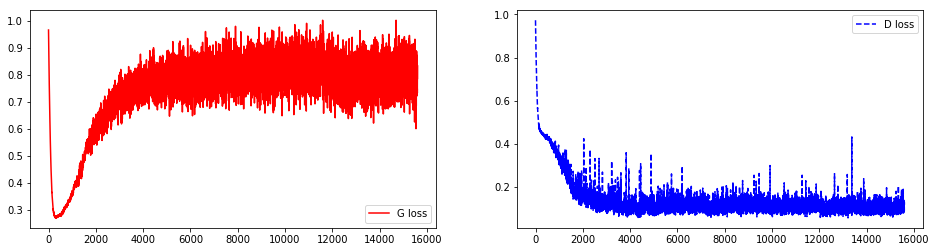

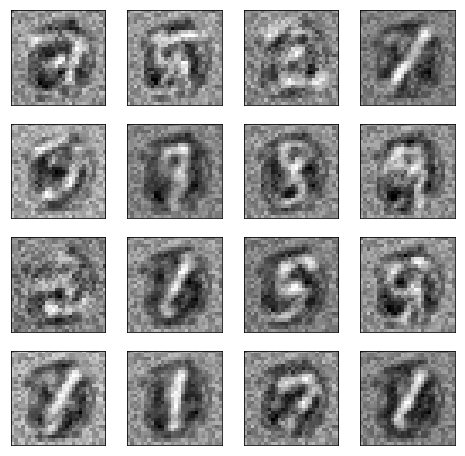

-------------------------------------------------------------------
[epoch 27], [training time 8.76]
-------------------------------------------------------------------


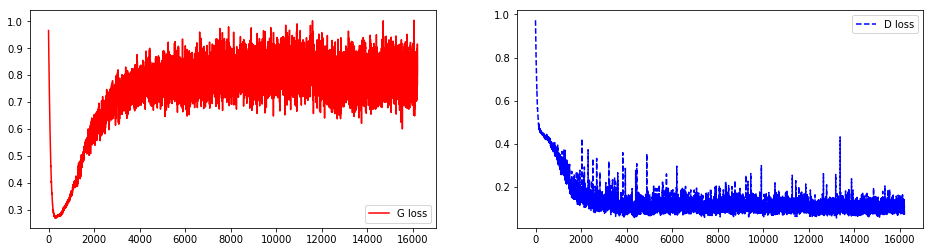

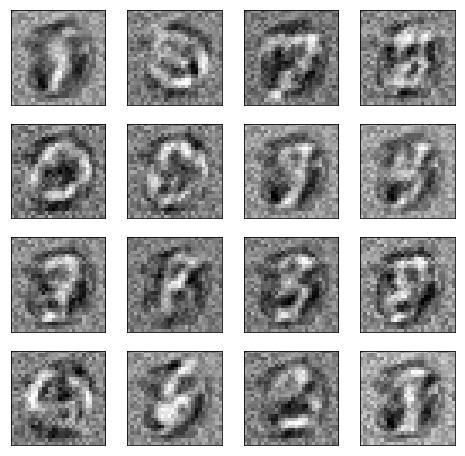

-------------------------------------------------------------------
[epoch 28], [training time 8.77]
-------------------------------------------------------------------


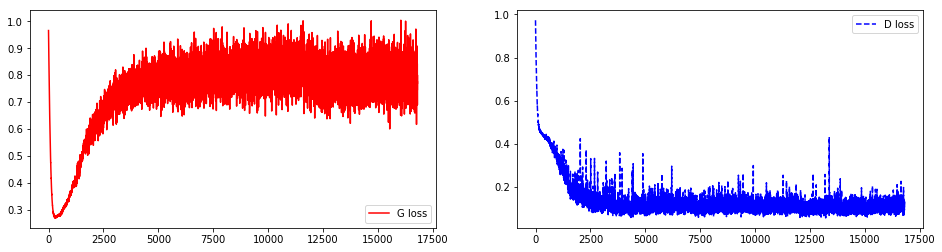

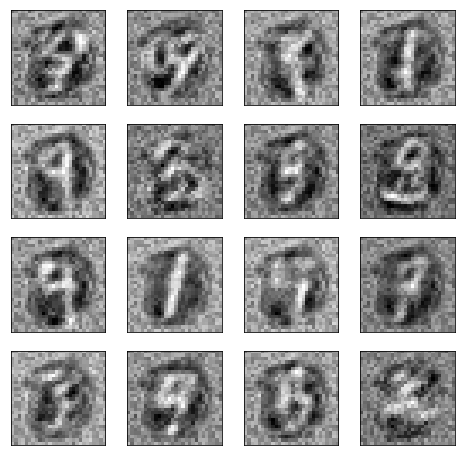

-------------------------------------------------------------------
[epoch 29], [training time 9.77]
-------------------------------------------------------------------


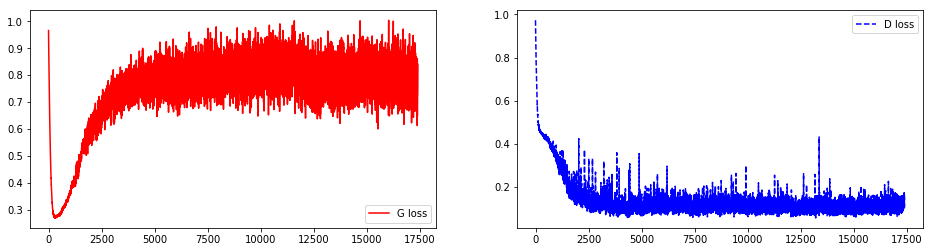

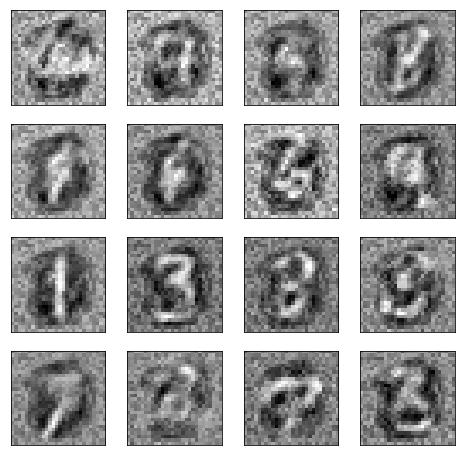

-------------------------------------------------------------------
[epoch 30], [training time 8.84]
-------------------------------------------------------------------


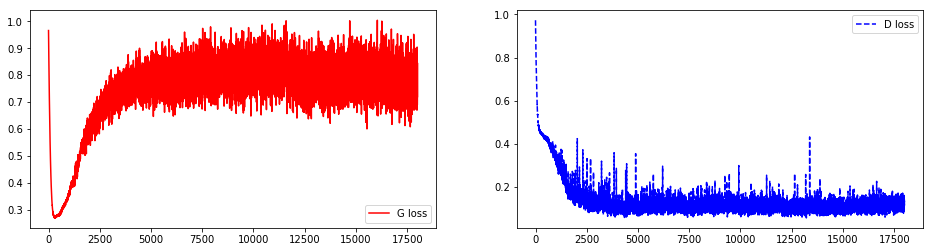

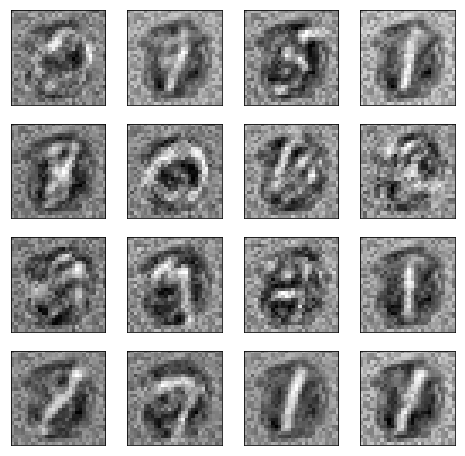

-------------------------------------------------------------------
[epoch 31], [training time 8.79]
-------------------------------------------------------------------


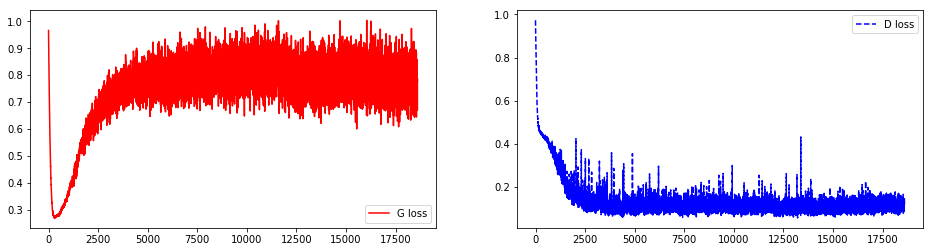

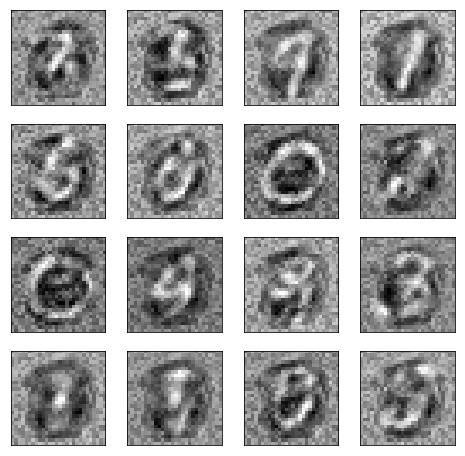

-------------------------------------------------------------------
[epoch 32], [training time 8.78]
-------------------------------------------------------------------


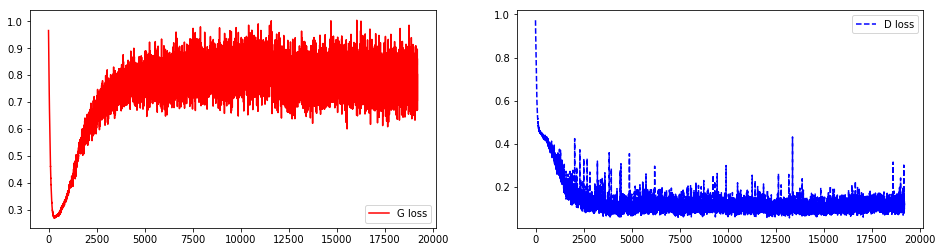

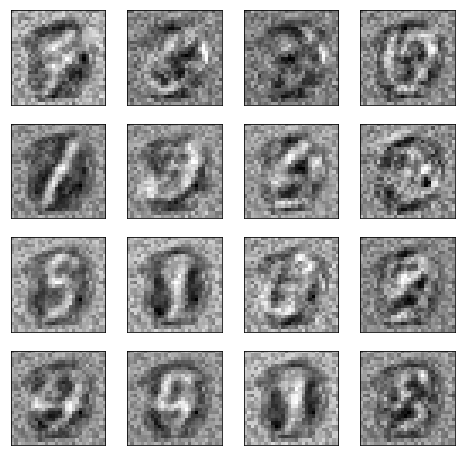

-------------------------------------------------------------------
[epoch 33], [training time 8.78]
-------------------------------------------------------------------


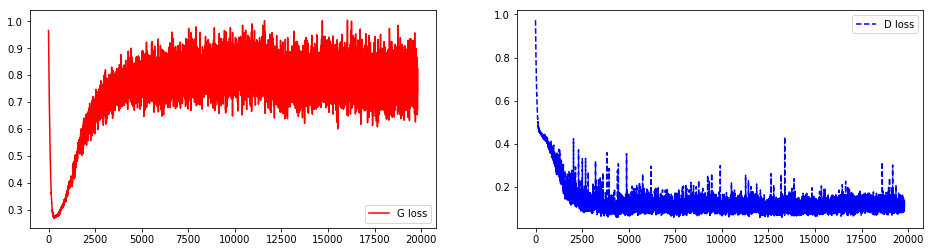

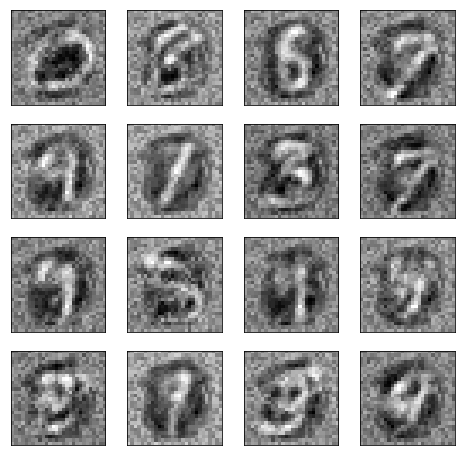

-------------------------------------------------------------------
[epoch 34], [training time 8.78]
-------------------------------------------------------------------


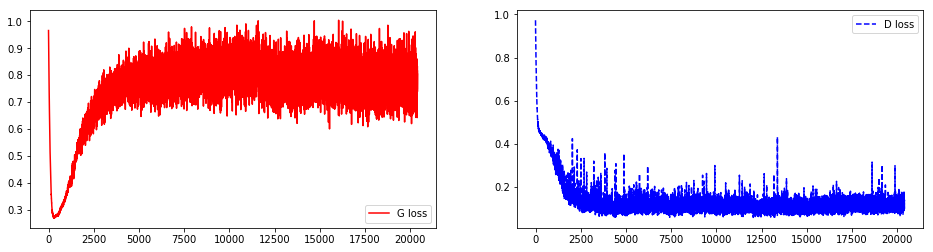

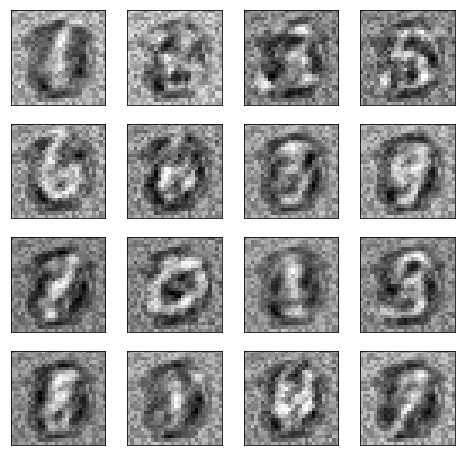

-------------------------------------------------------------------
[epoch 35], [training time 8.76]
-------------------------------------------------------------------


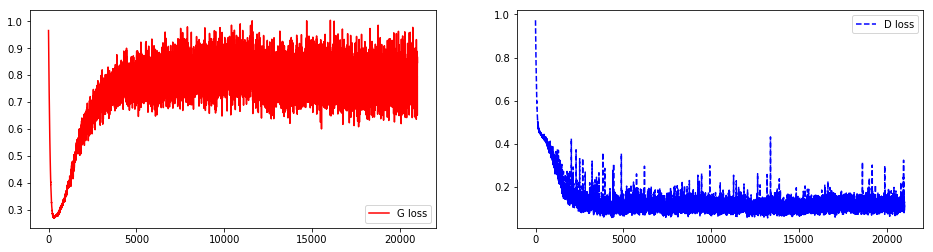

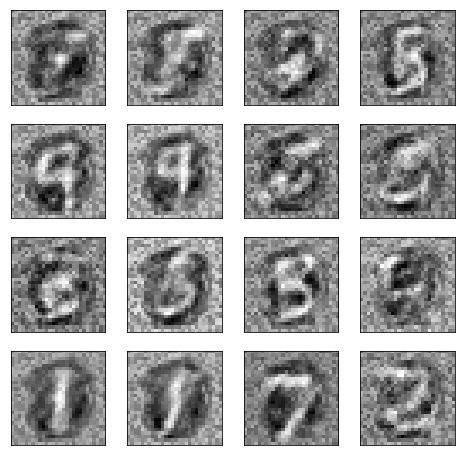

-------------------------------------------------------------------
[epoch 36], [training time 8.80]
-------------------------------------------------------------------


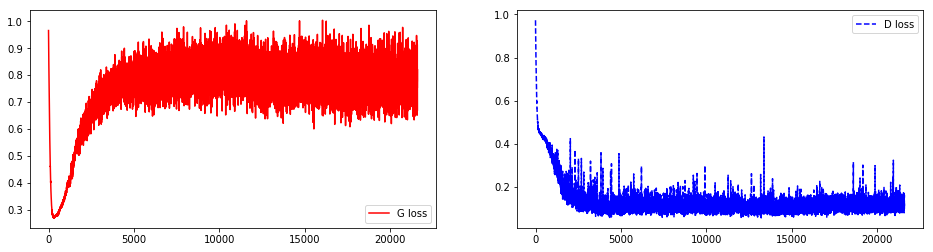

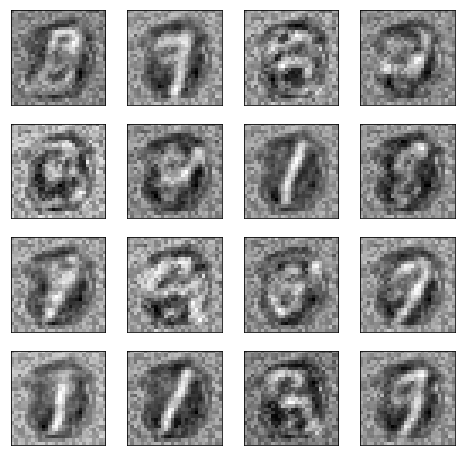

-------------------------------------------------------------------
[epoch 37], [training time 8.82]
-------------------------------------------------------------------


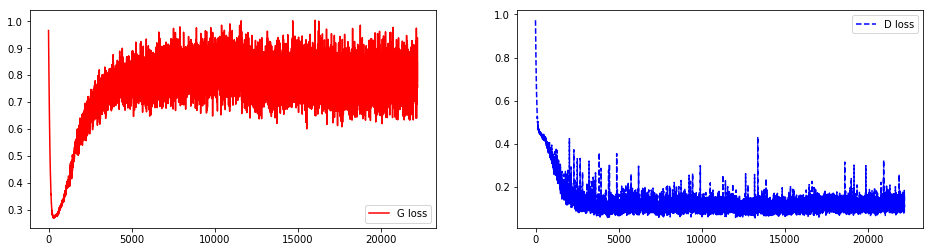

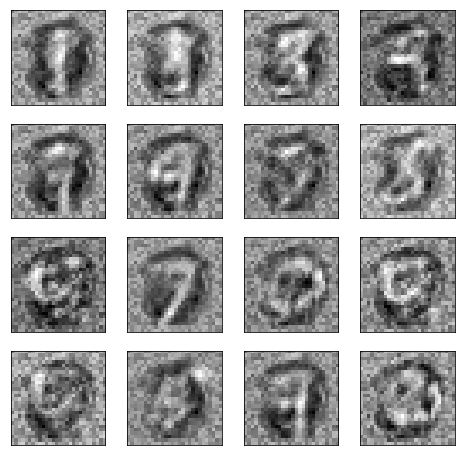

-------------------------------------------------------------------
[epoch 38], [training time 9.01]
-------------------------------------------------------------------


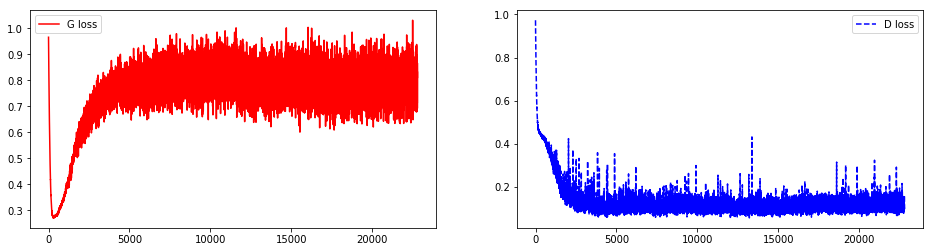

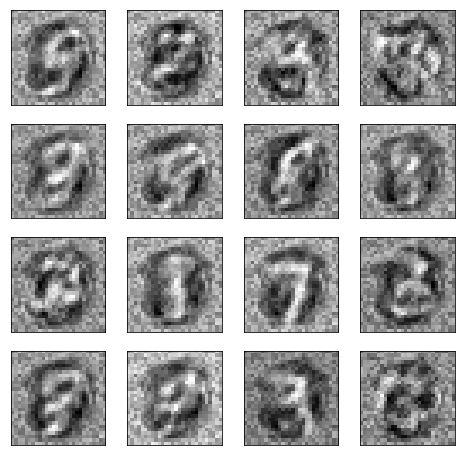

-------------------------------------------------------------------
[epoch 39], [training time 8.89]
-------------------------------------------------------------------


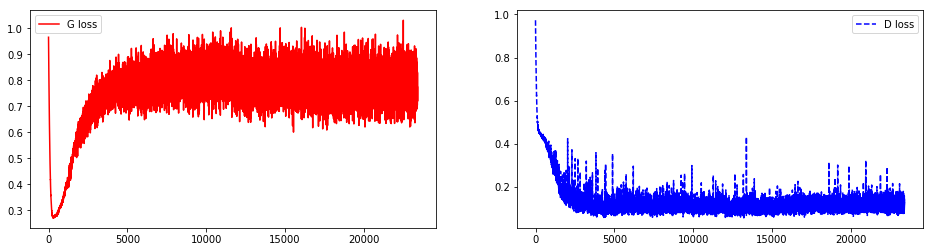

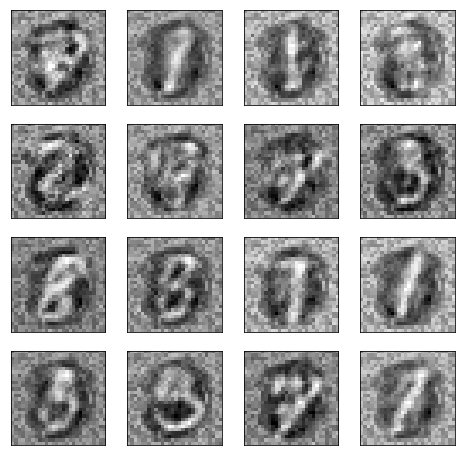

-------------------------------------------------------------------
[epoch 40], [training time 9.63]
-------------------------------------------------------------------


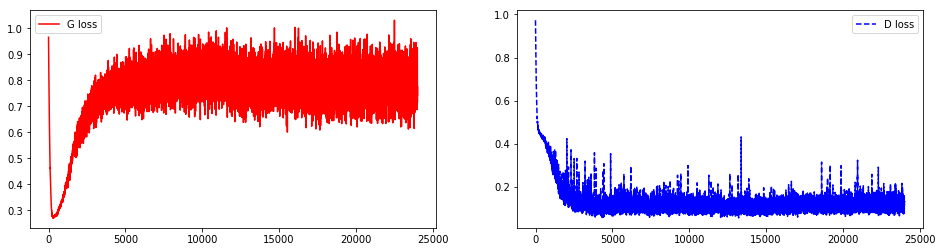

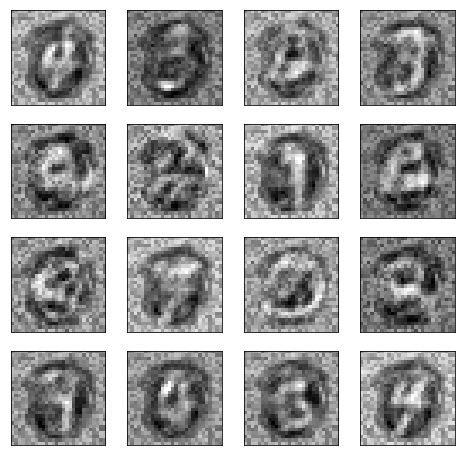

-------------------------------------------------------------------
[epoch 41], [training time 8.81]
-------------------------------------------------------------------


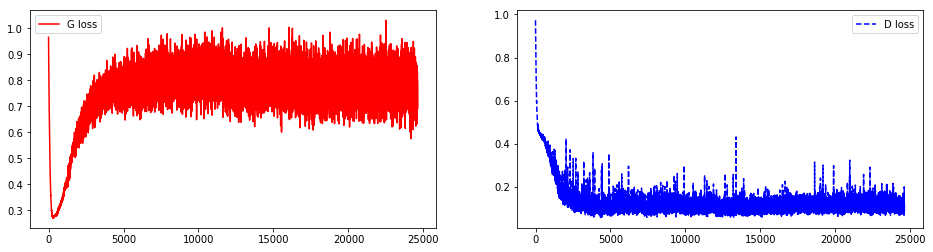

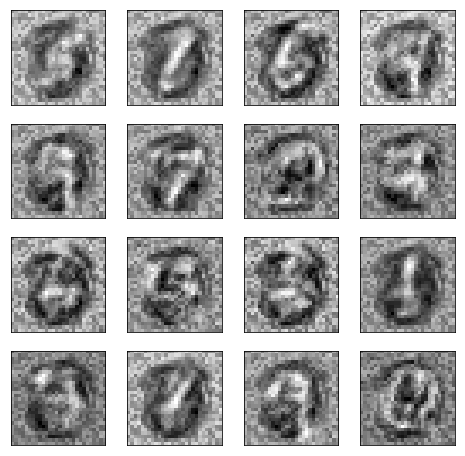

-------------------------------------------------------------------
[epoch 42], [training time 8.80]
-------------------------------------------------------------------


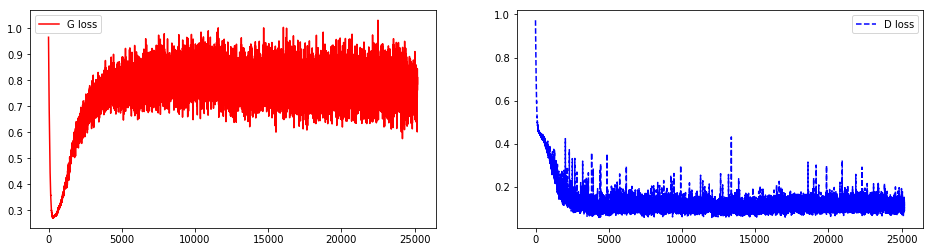

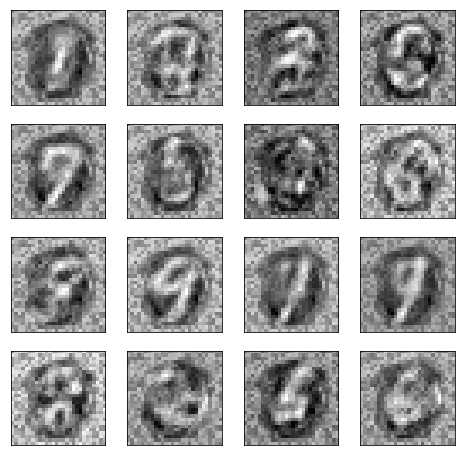

-------------------------------------------------------------------
[epoch 43], [training time 8.83]
-------------------------------------------------------------------


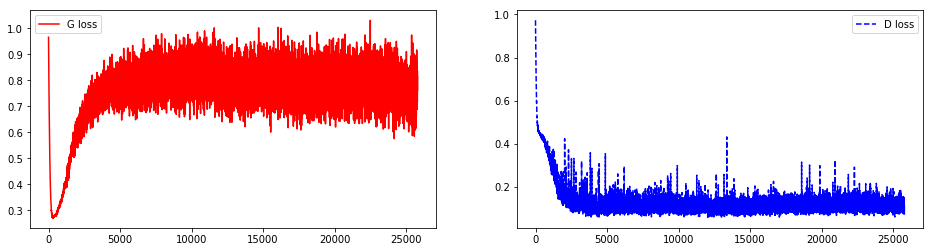

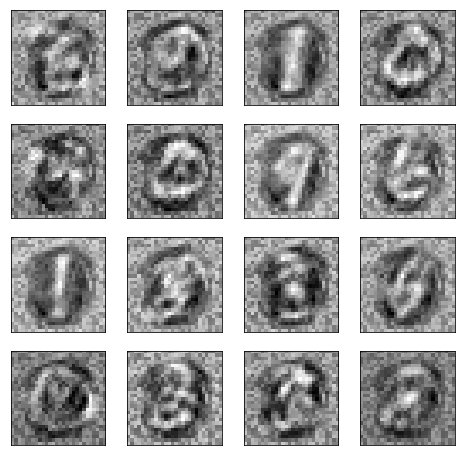

-------------------------------------------------------------------
[epoch 44], [training time 8.84]
-------------------------------------------------------------------


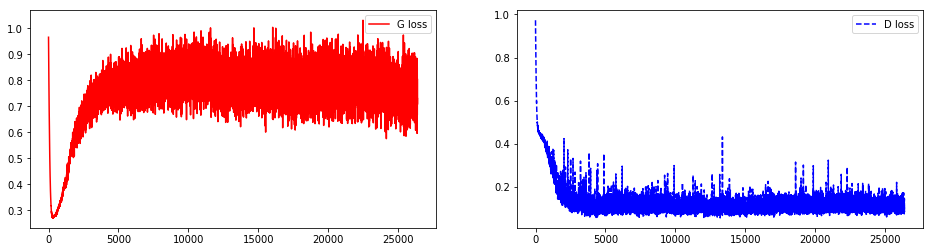

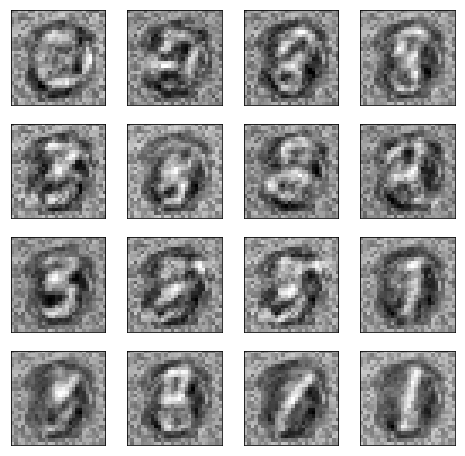

-------------------------------------------------------------------
[epoch 45], [training time 8.79]
-------------------------------------------------------------------


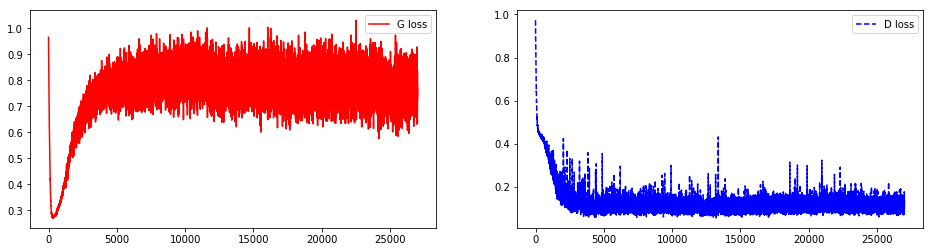

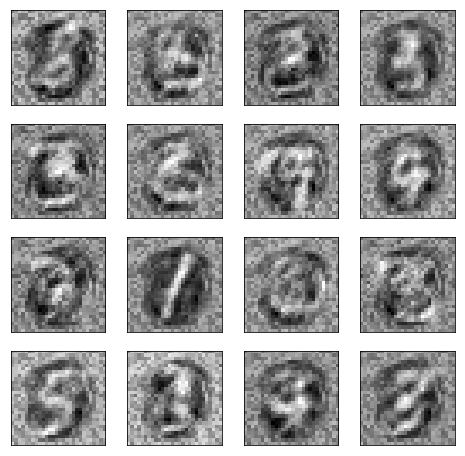

-------------------------------------------------------------------
[epoch 46], [training time 8.94]
-------------------------------------------------------------------


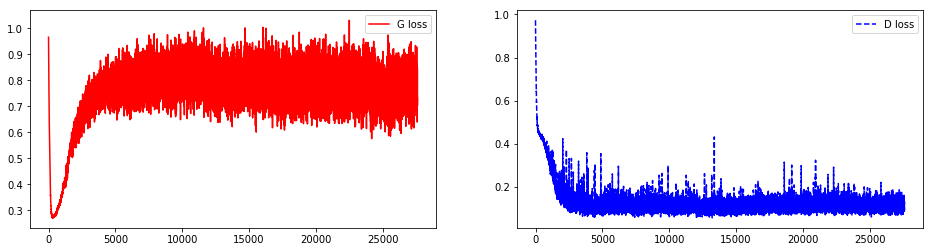

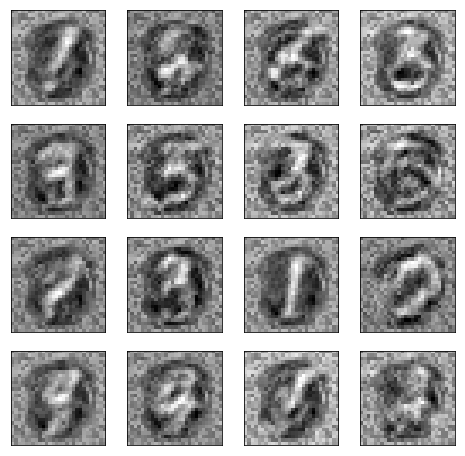

-------------------------------------------------------------------
[epoch 47], [training time 8.82]
-------------------------------------------------------------------


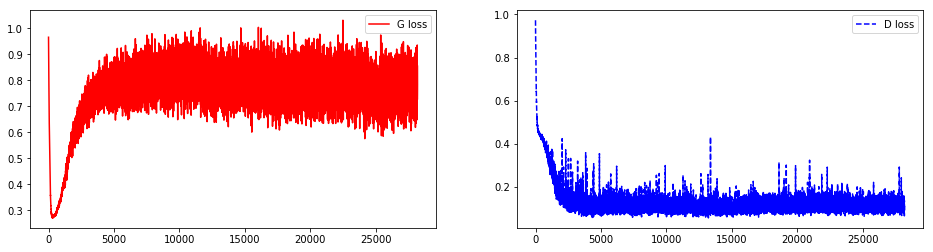

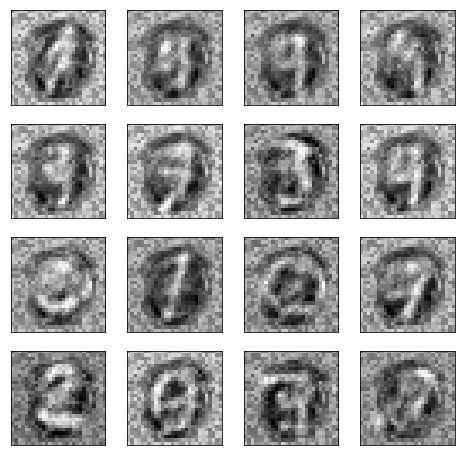

-------------------------------------------------------------------
[epoch 48], [training time 8.81]
-------------------------------------------------------------------


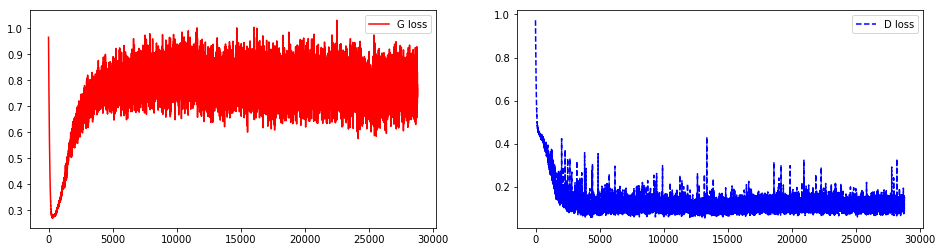

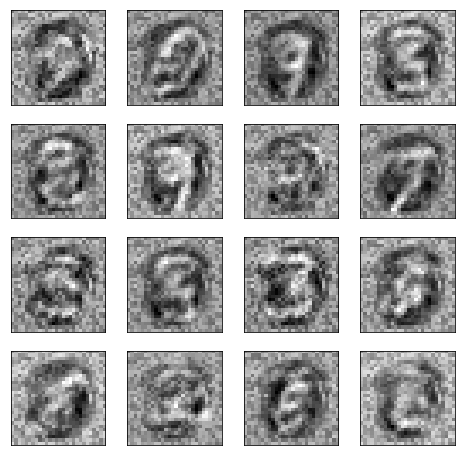

-------------------------------------------------------------------
[epoch 49], [training time 8.89]
-------------------------------------------------------------------


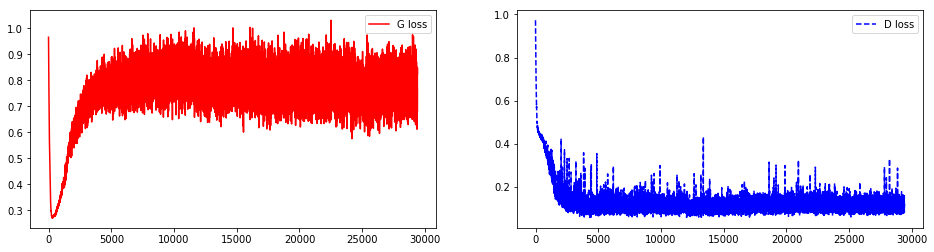

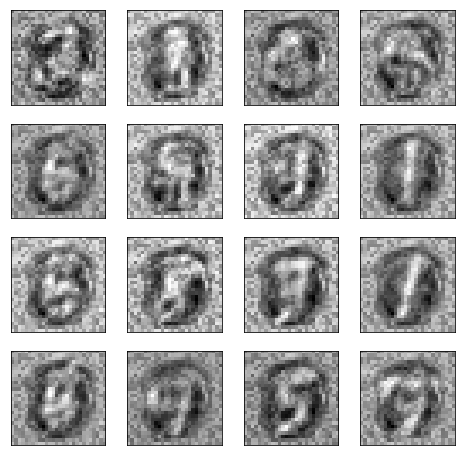

-------------------------------------------------------------------
[epoch 50], [training time 8.81]
-------------------------------------------------------------------


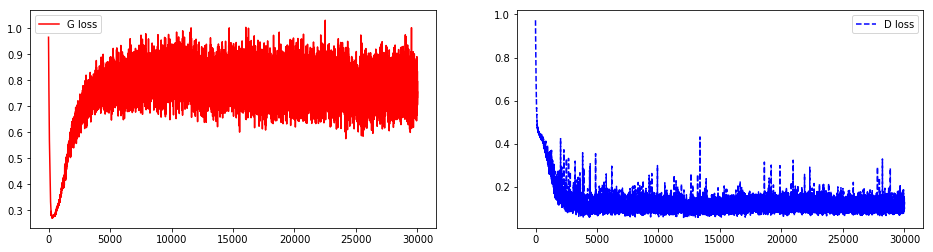

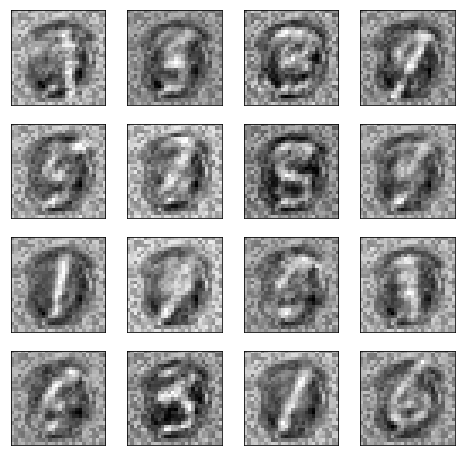

-------------------------------------------------------------------
[epoch 51], [training time 9.73]
-------------------------------------------------------------------


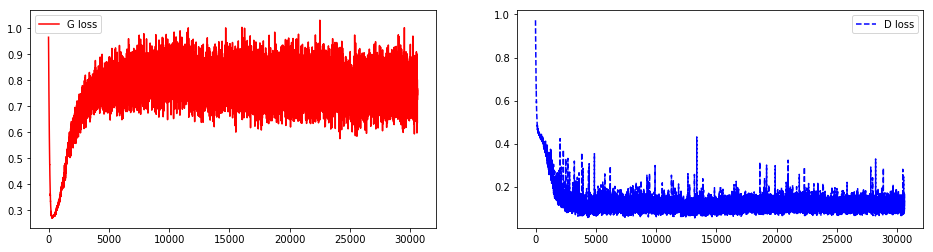

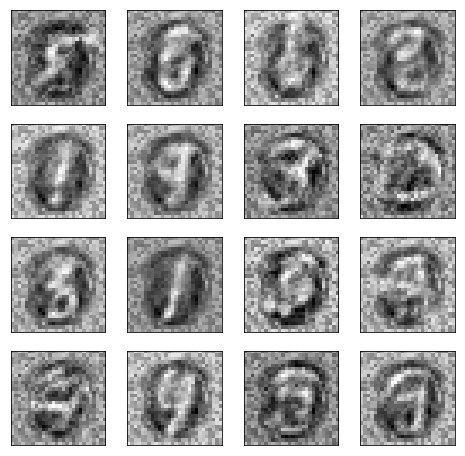

-------------------------------------------------------------------
[epoch 52], [training time 8.83]
-------------------------------------------------------------------


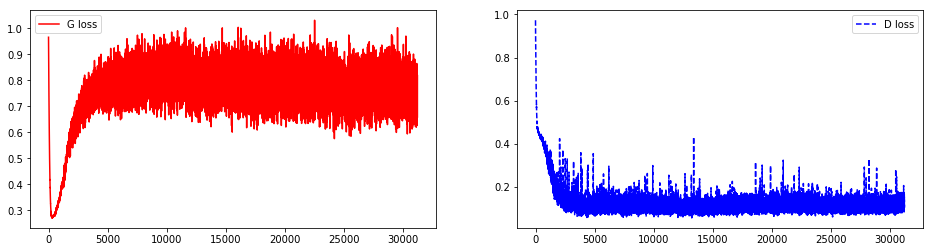

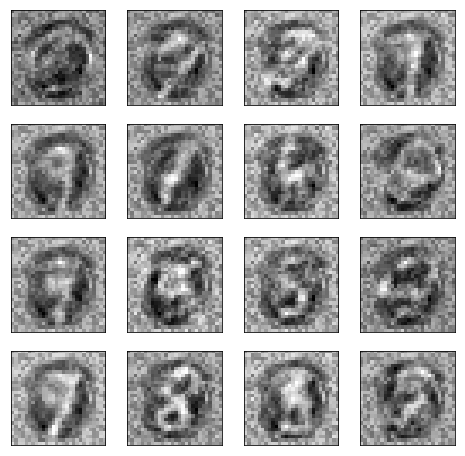

-------------------------------------------------------------------
[epoch 53], [training time 8.82]
-------------------------------------------------------------------


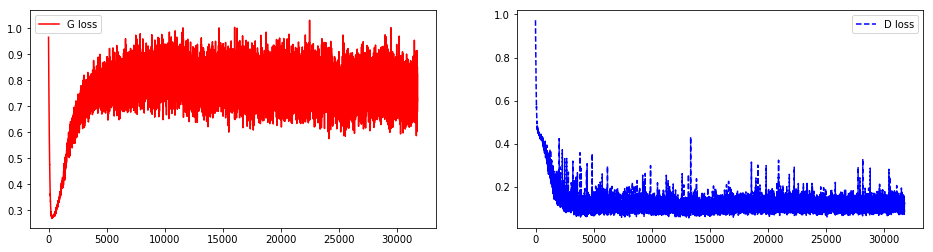

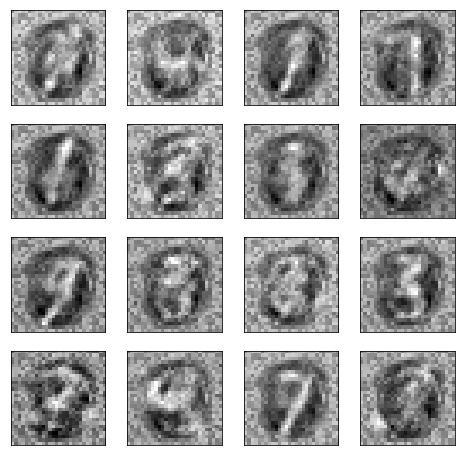

-------------------------------------------------------------------
[epoch 54], [training time 8.92]
-------------------------------------------------------------------


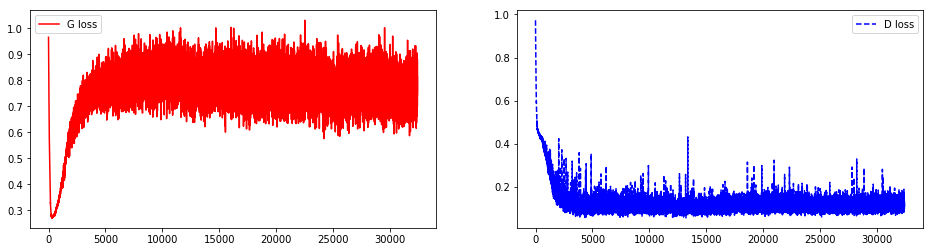

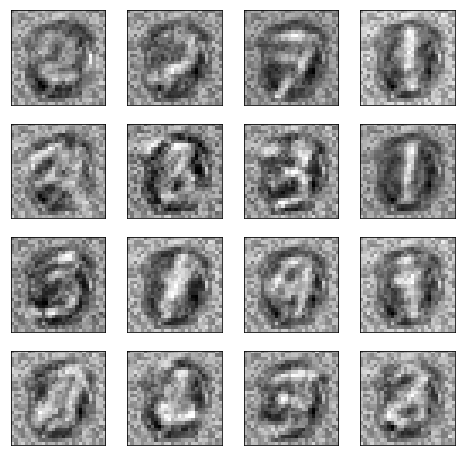

-------------------------------------------------------------------
[epoch 55], [training time 8.86]
-------------------------------------------------------------------


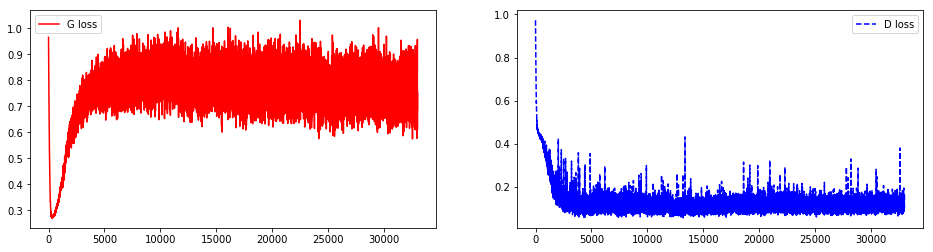

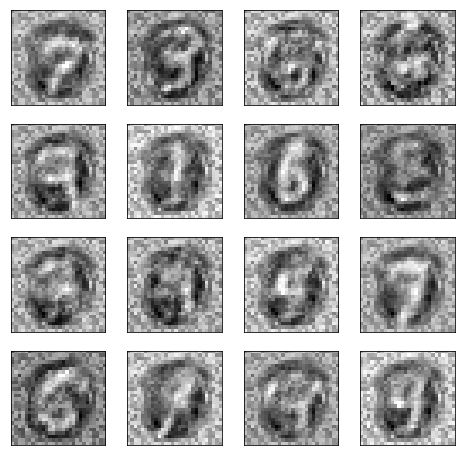

-------------------------------------------------------------------
[epoch 56], [training time 8.77]
-------------------------------------------------------------------


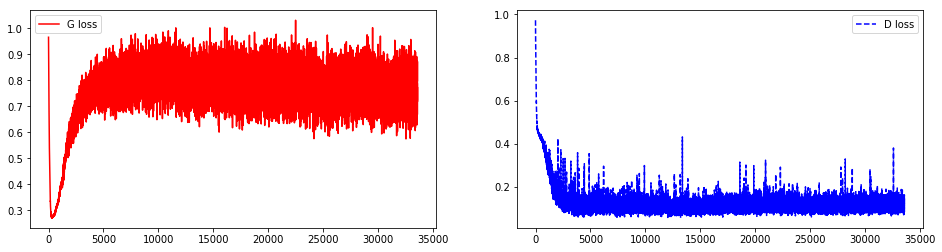

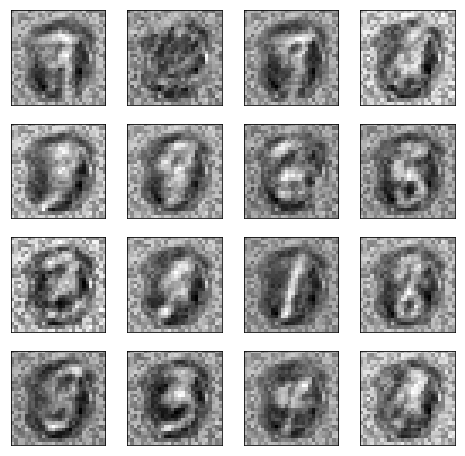

-------------------------------------------------------------------
[epoch 57], [training time 8.81]
-------------------------------------------------------------------


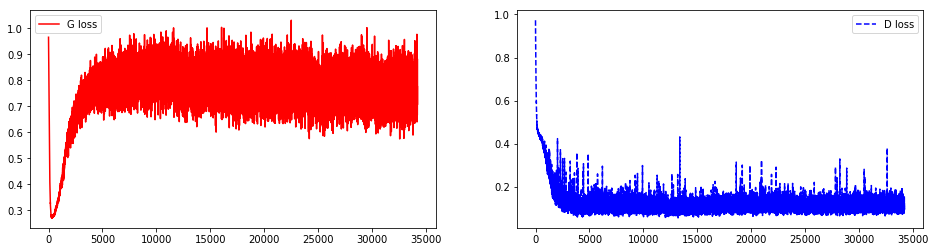

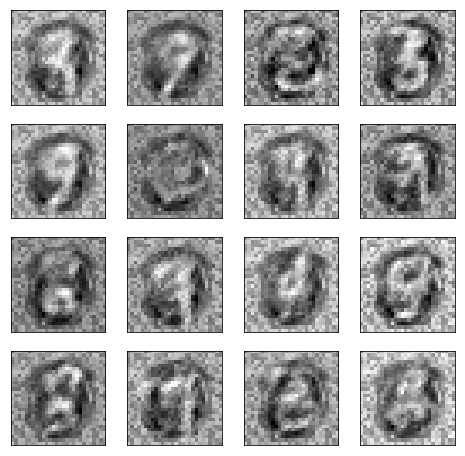

-------------------------------------------------------------------
[epoch 58], [training time 8.81]
-------------------------------------------------------------------


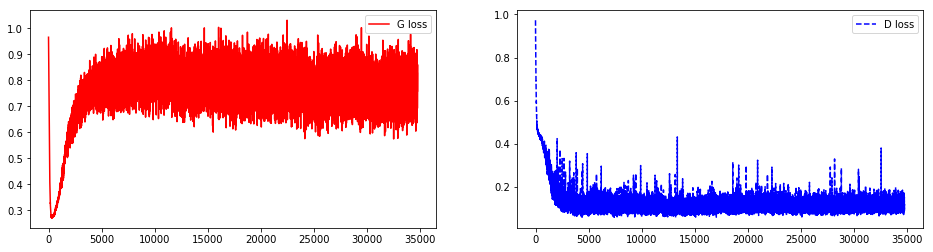

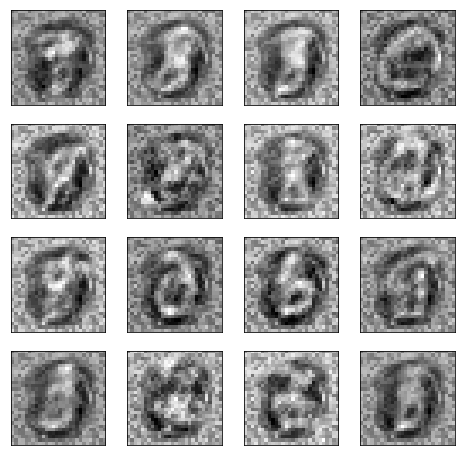

-------------------------------------------------------------------
[epoch 59], [training time 8.82]
-------------------------------------------------------------------


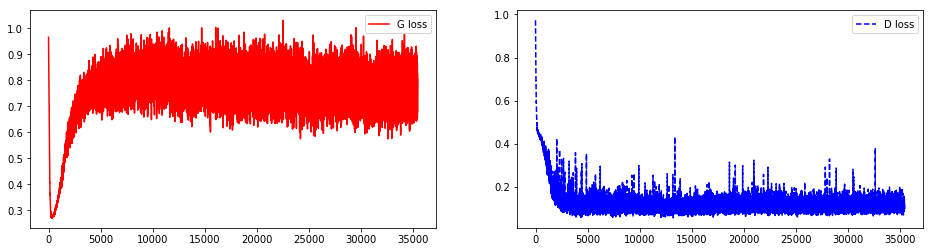

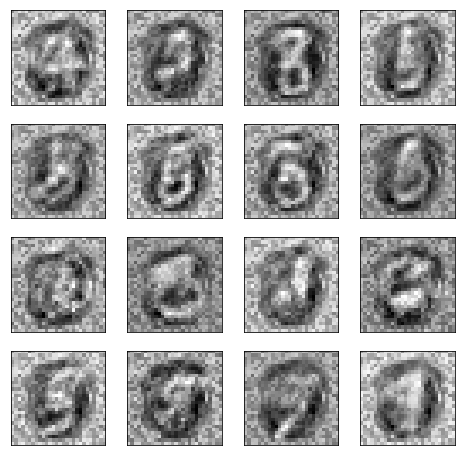

-------------------------------------------------------------------
[epoch 60], [training time 8.81]
-------------------------------------------------------------------


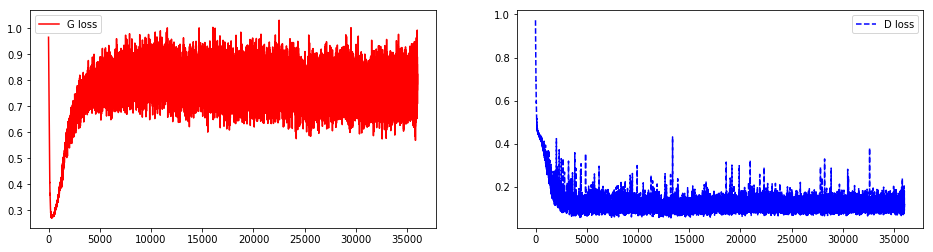

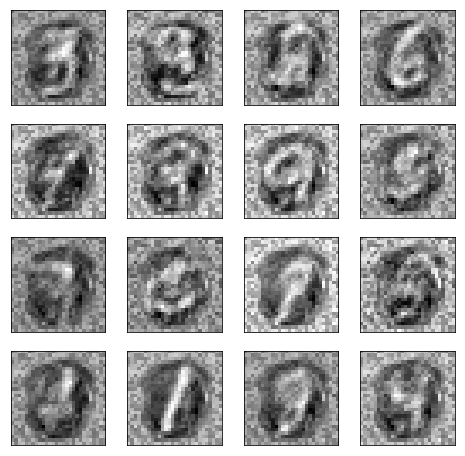

-------------------------------------------------------------------
[epoch 61], [training time 8.83]
-------------------------------------------------------------------


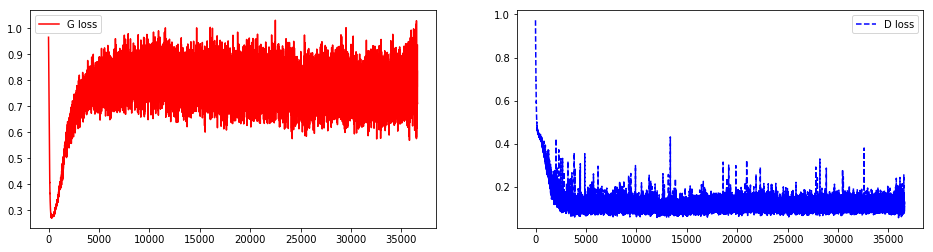

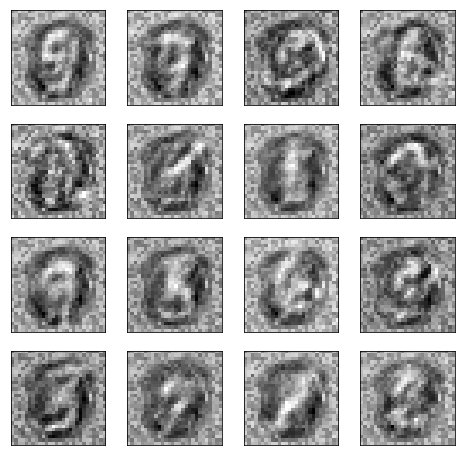

-------------------------------------------------------------------
[epoch 62], [training time 9.85]
-------------------------------------------------------------------


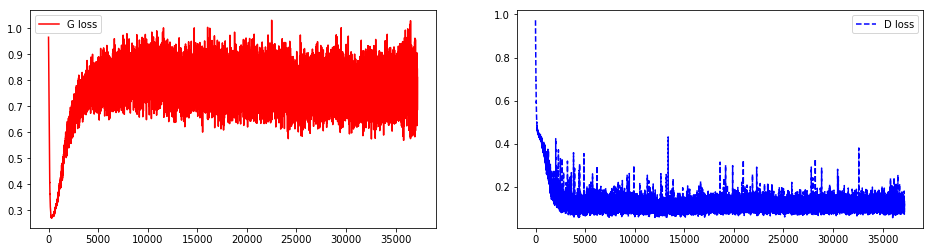

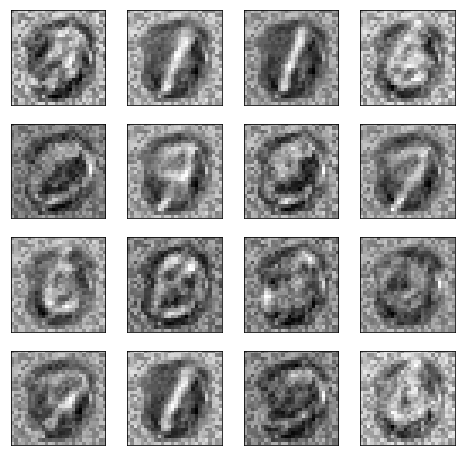

-------------------------------------------------------------------
[epoch 63], [training time 8.79]
-------------------------------------------------------------------


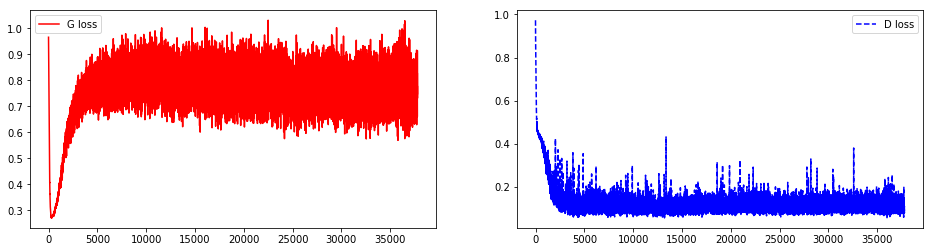

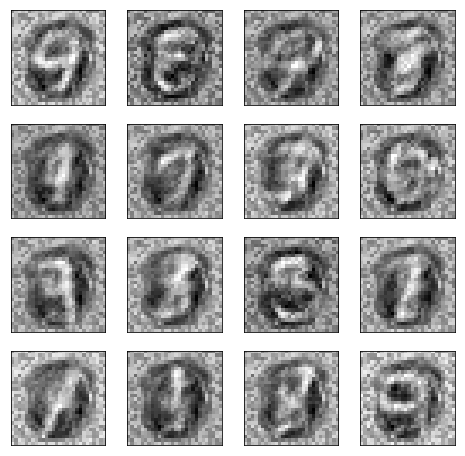

-------------------------------------------------------------------
[epoch 64], [training time 8.81]
-------------------------------------------------------------------


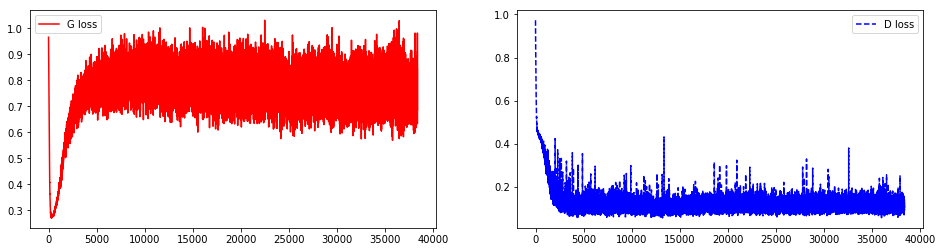

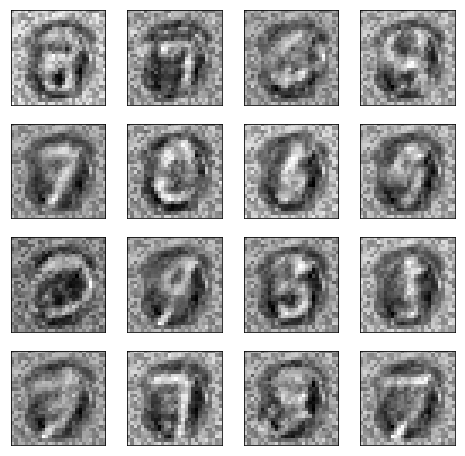

-------------------------------------------------------------------
[epoch 65], [training time 8.76]
-------------------------------------------------------------------


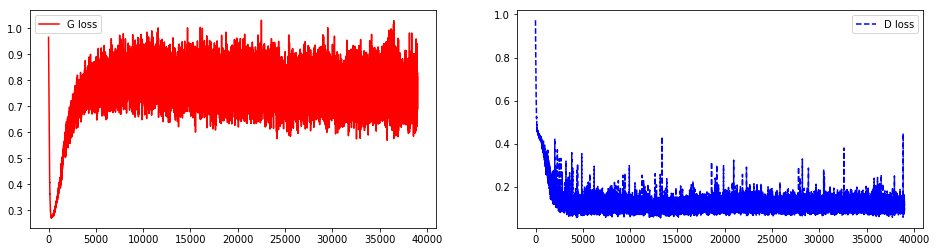

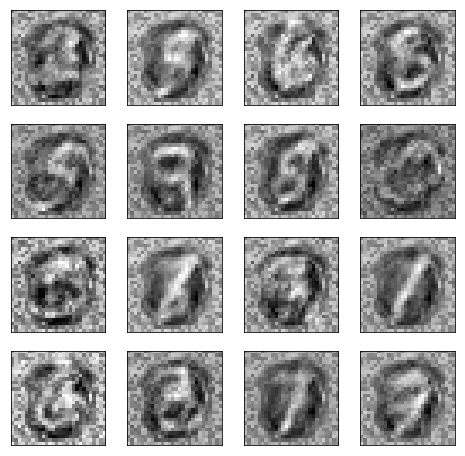

-------------------------------------------------------------------
[epoch 66], [training time 8.79]
-------------------------------------------------------------------


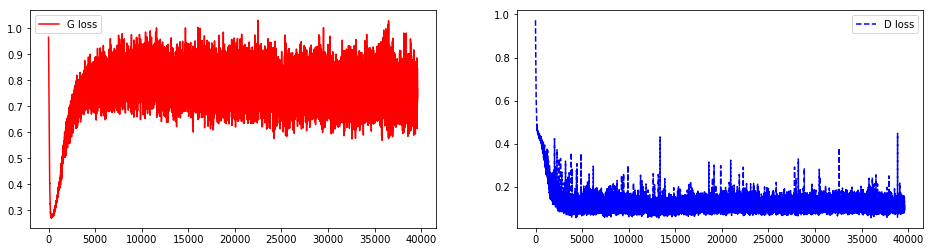

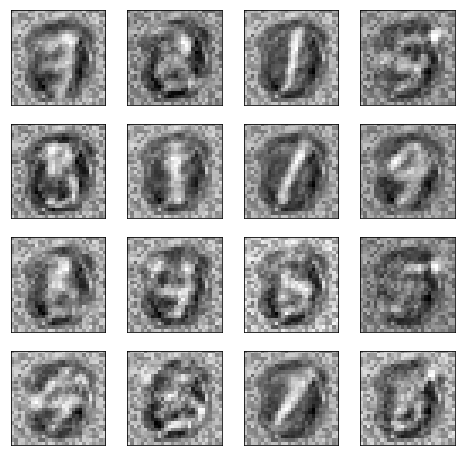

-------------------------------------------------------------------
[epoch 67], [training time 8.80]
-------------------------------------------------------------------


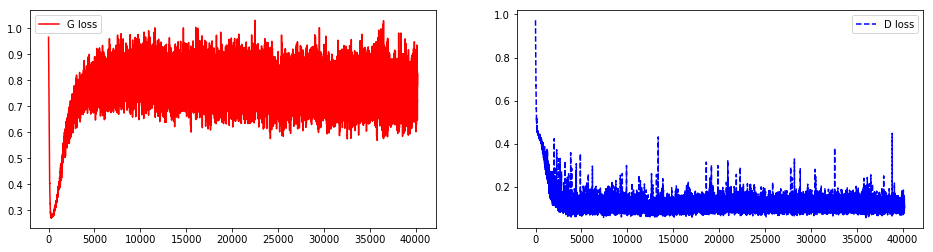

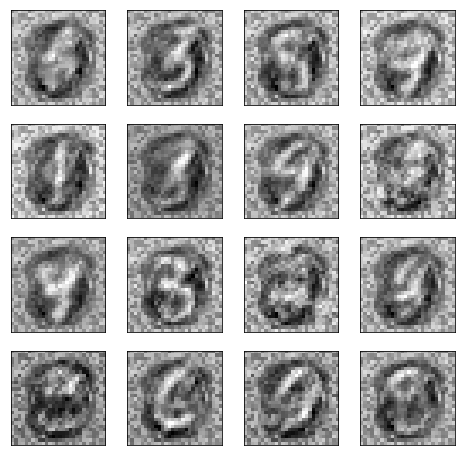

-------------------------------------------------------------------
[epoch 68], [training time 8.80]
-------------------------------------------------------------------


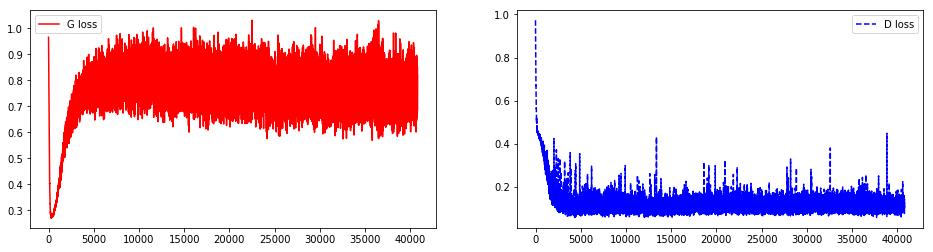

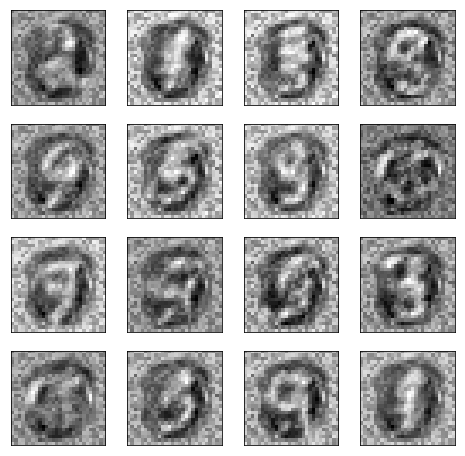

-------------------------------------------------------------------
[epoch 69], [training time 8.97]
-------------------------------------------------------------------


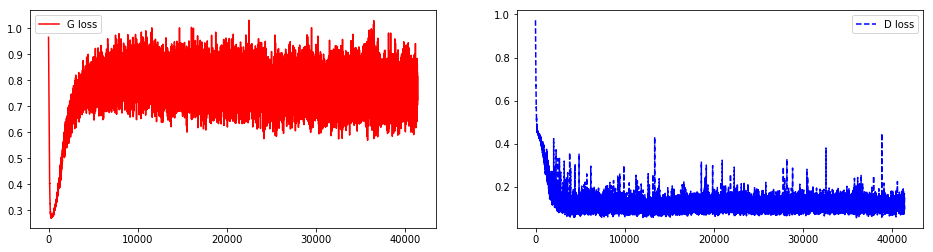

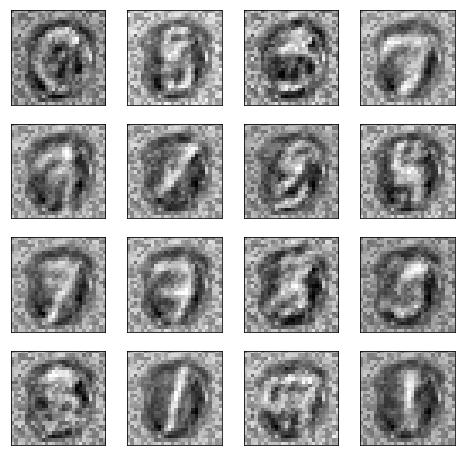

-------------------------------------------------------------------
[epoch 70], [training time 9.01]
-------------------------------------------------------------------


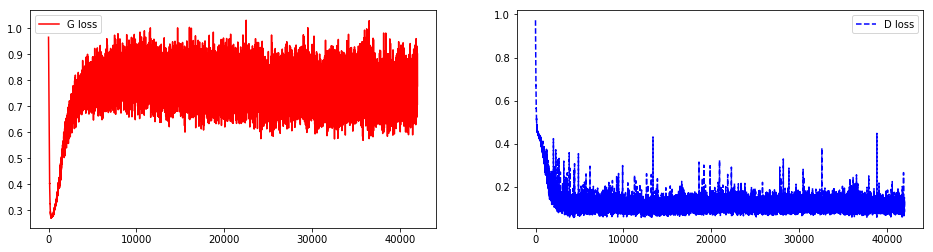

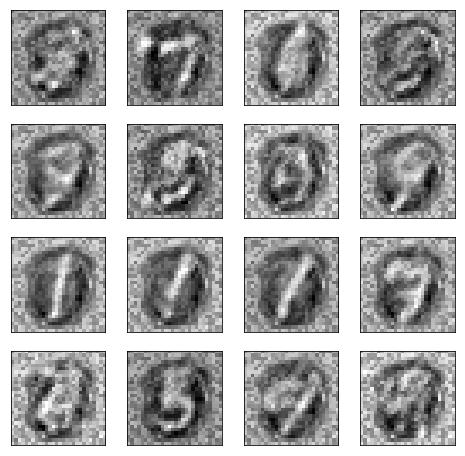

-------------------------------------------------------------------
[epoch 71], [training time 8.85]
-------------------------------------------------------------------


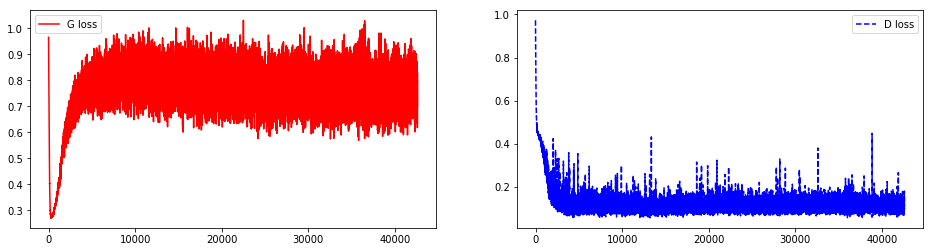

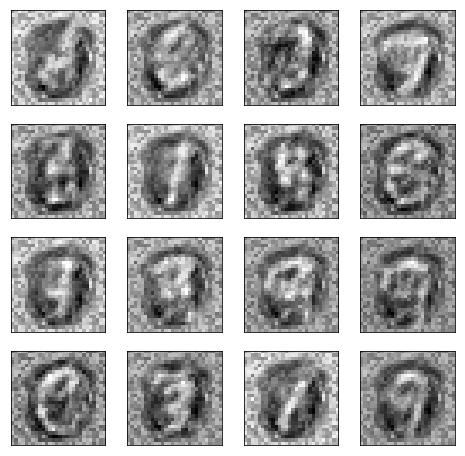

-------------------------------------------------------------------
[epoch 72], [training time 8.85]
-------------------------------------------------------------------


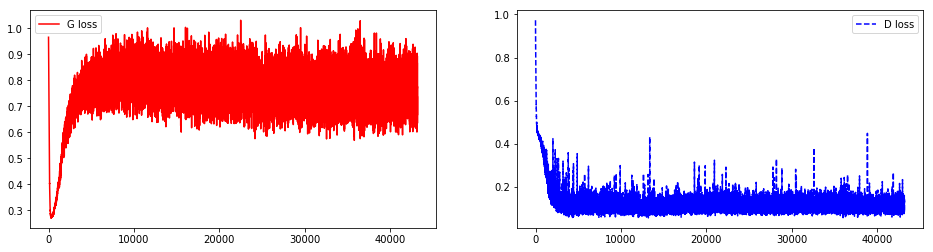

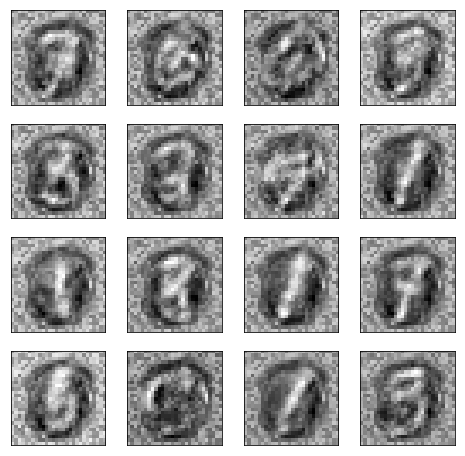

-------------------------------------------------------------------
[epoch 73], [training time 9.84]
-------------------------------------------------------------------


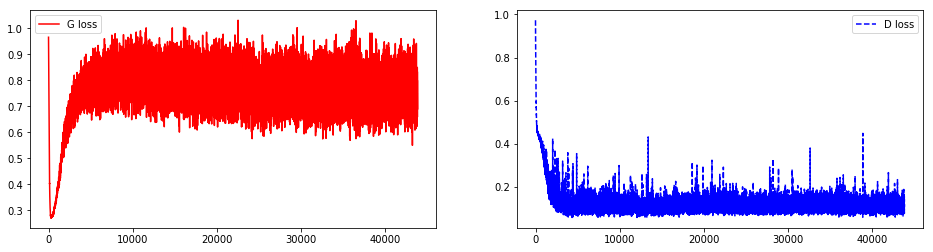

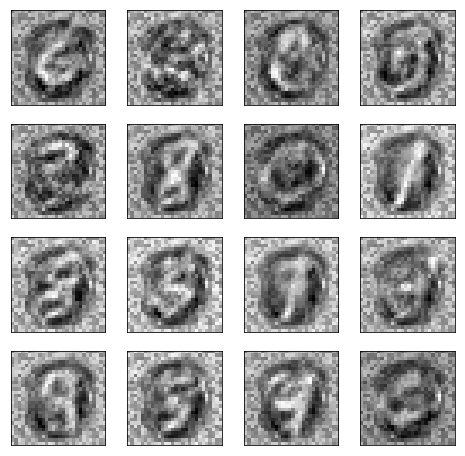

-------------------------------------------------------------------
[epoch 74], [training time 8.79]
-------------------------------------------------------------------


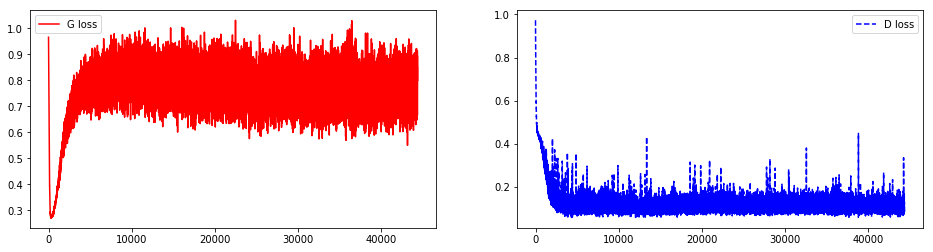

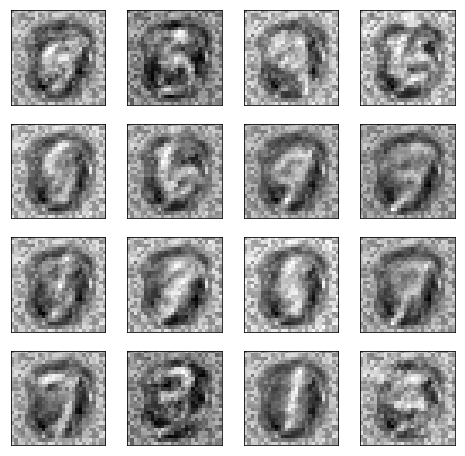

-------------------------------------------------------------------
[epoch 75], [training time 8.82]
-------------------------------------------------------------------


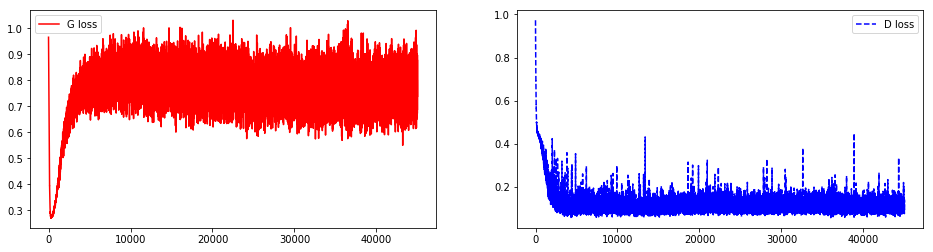

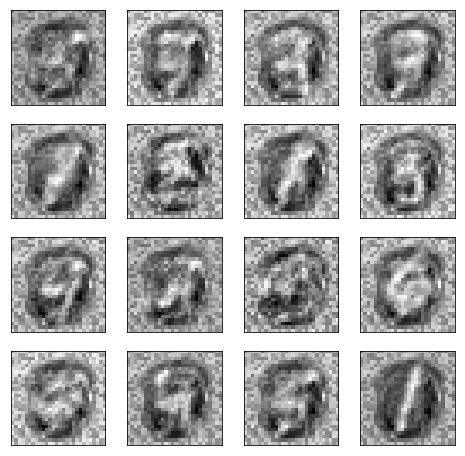

-------------------------------------------------------------------
[epoch 76], [training time 8.83]
-------------------------------------------------------------------


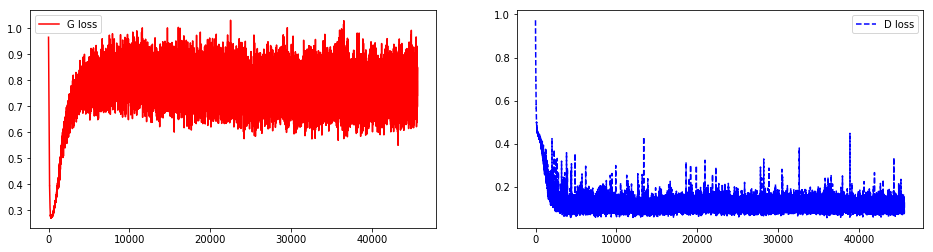

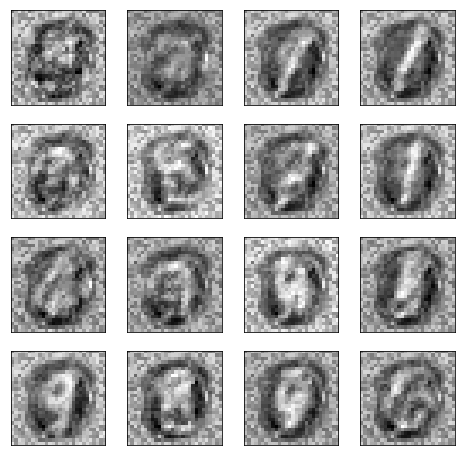

-------------------------------------------------------------------
[epoch 77], [training time 8.82]
-------------------------------------------------------------------


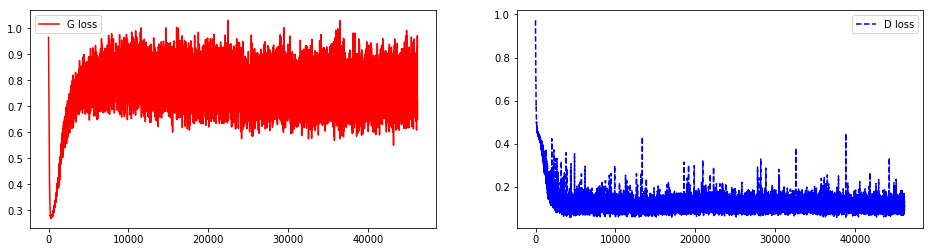

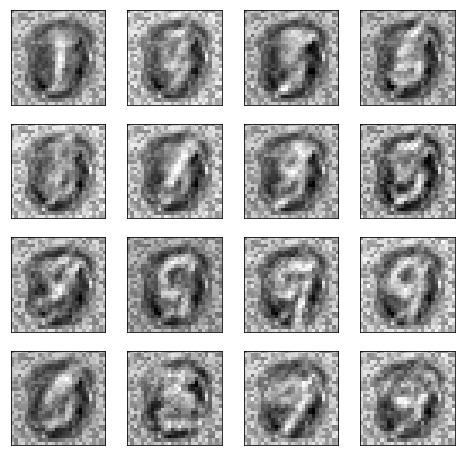

-------------------------------------------------------------------
[epoch 78], [training time 8.89]
-------------------------------------------------------------------


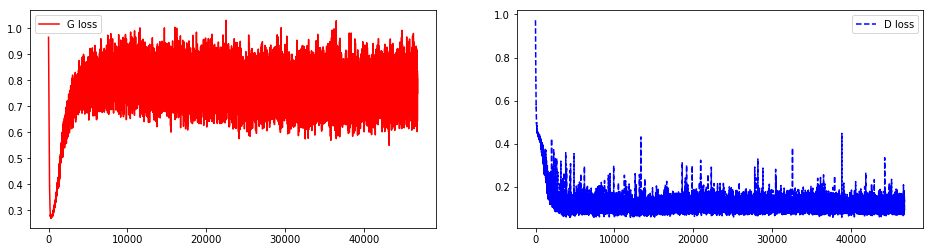

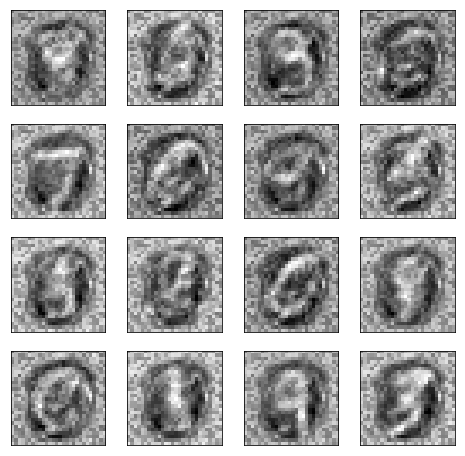

-------------------------------------------------------------------
[epoch 79], [training time 8.85]
-------------------------------------------------------------------


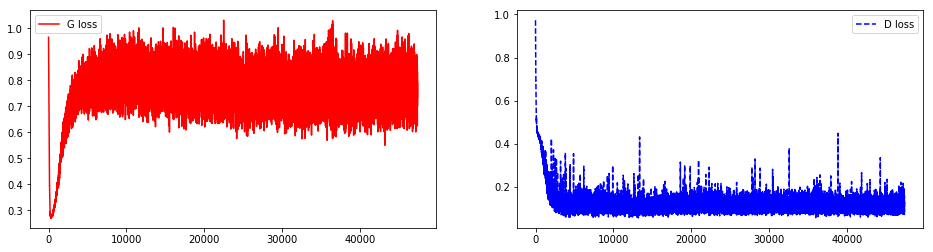

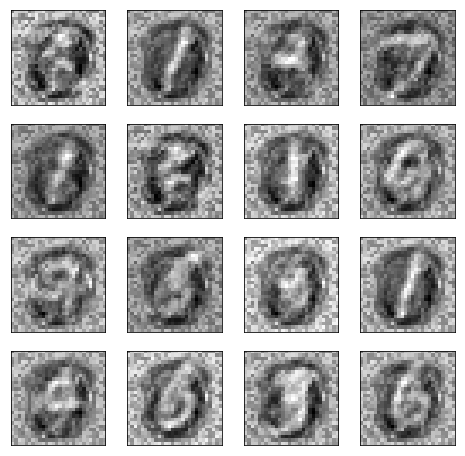

-------------------------------------------------------------------
[epoch 80], [training time 8.90]
-------------------------------------------------------------------


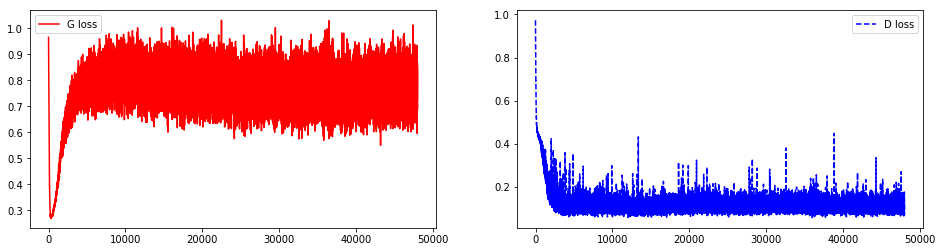

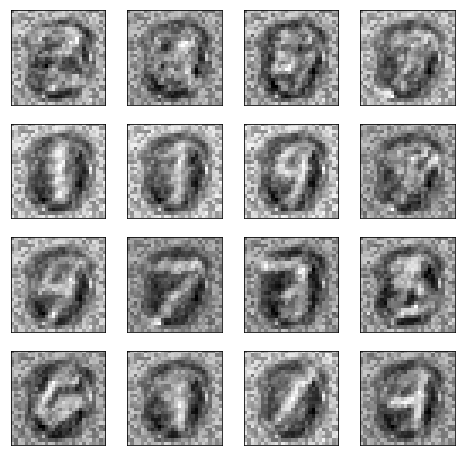

-------------------------------------------------------------------
[epoch 81], [training time 8.79]
-------------------------------------------------------------------


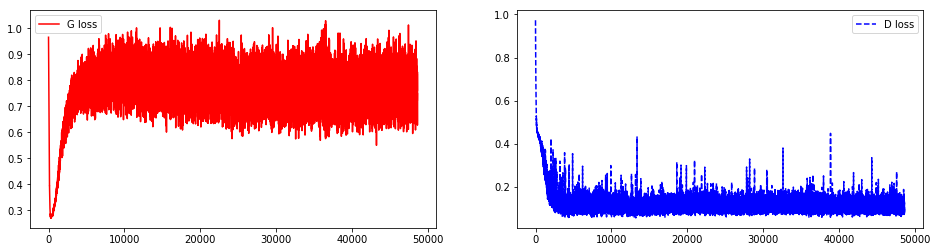

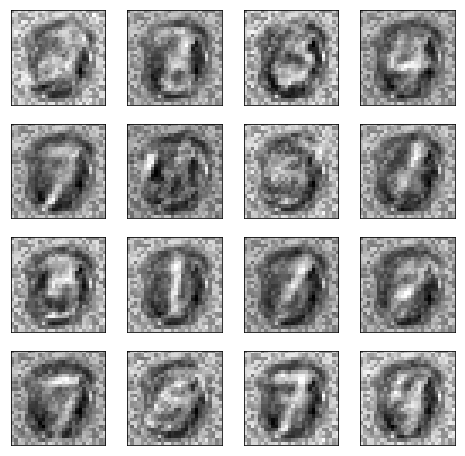

-------------------------------------------------------------------
[epoch 82], [training time 8.78]
-------------------------------------------------------------------


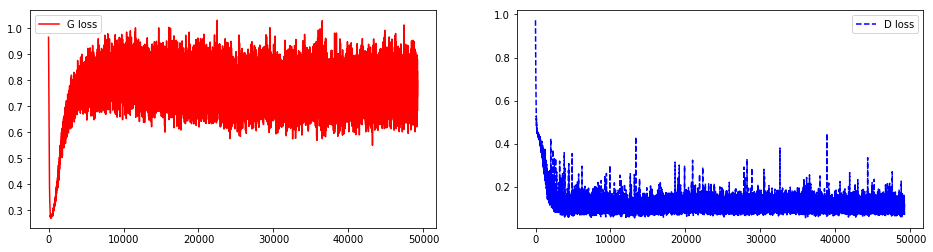

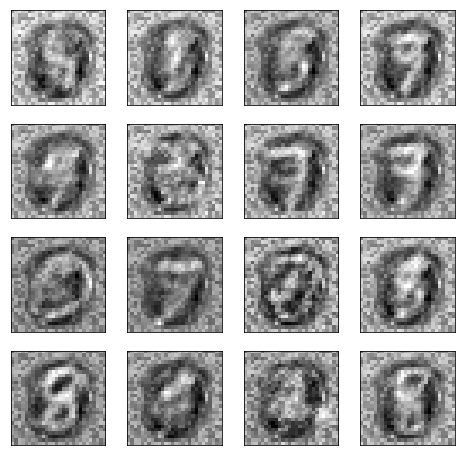

-------------------------------------------------------------------
[epoch 83], [training time 8.79]
-------------------------------------------------------------------


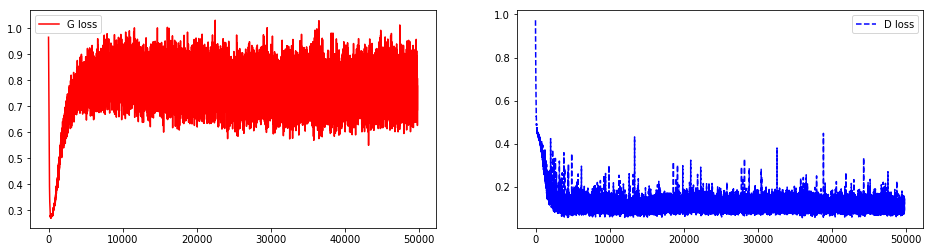

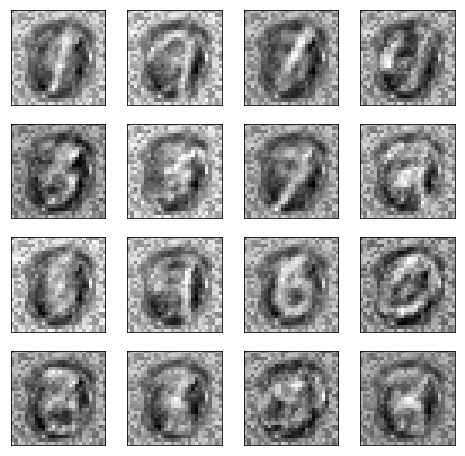

-------------------------------------------------------------------
[epoch 84], [training time 9.87]
-------------------------------------------------------------------


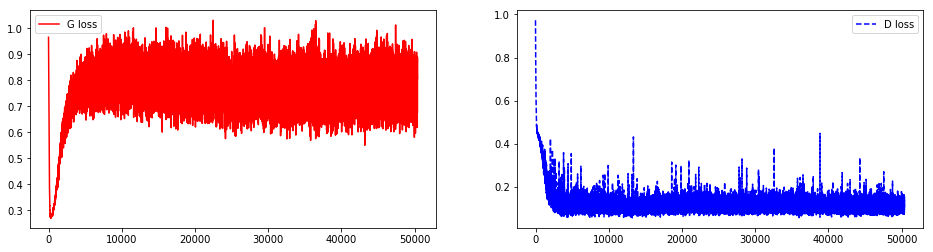

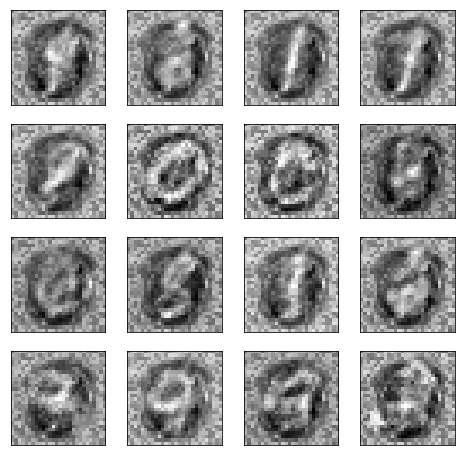

-------------------------------------------------------------------
[epoch 85], [training time 8.85]
-------------------------------------------------------------------


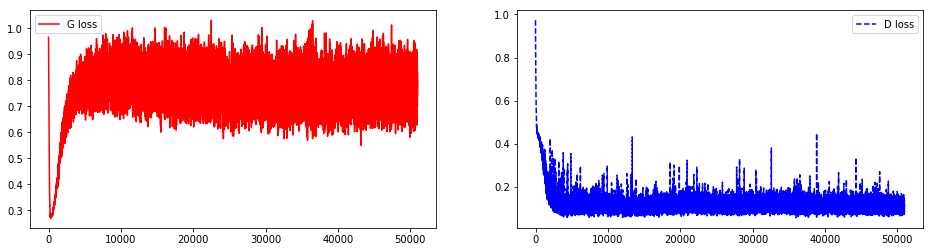

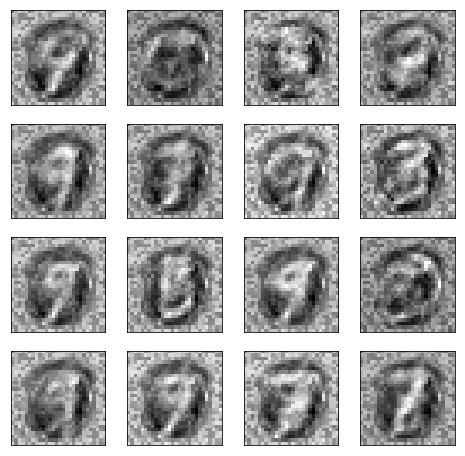

-------------------------------------------------------------------
[epoch 86], [training time 8.88]
-------------------------------------------------------------------


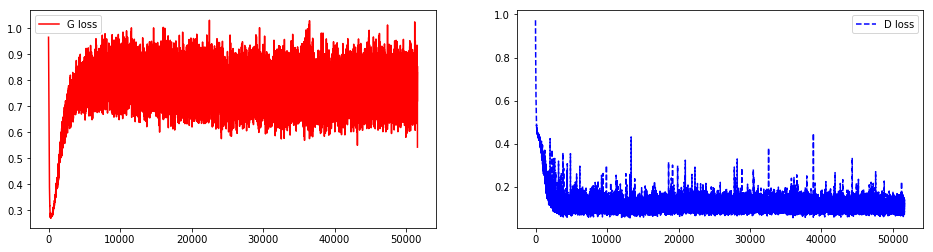

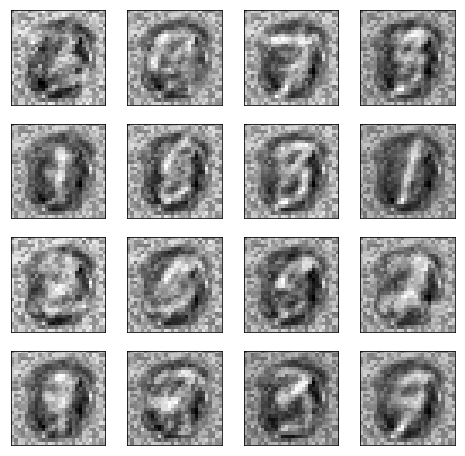

-------------------------------------------------------------------
[epoch 87], [training time 8.81]
-------------------------------------------------------------------


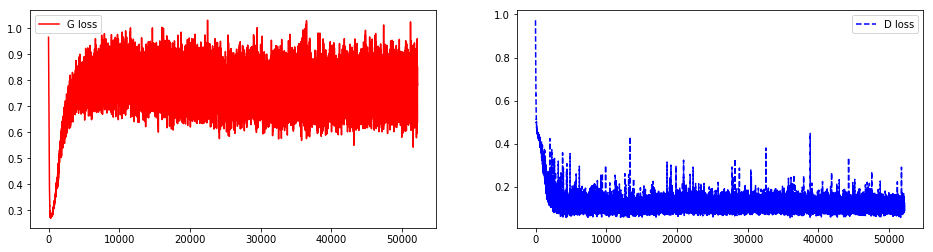

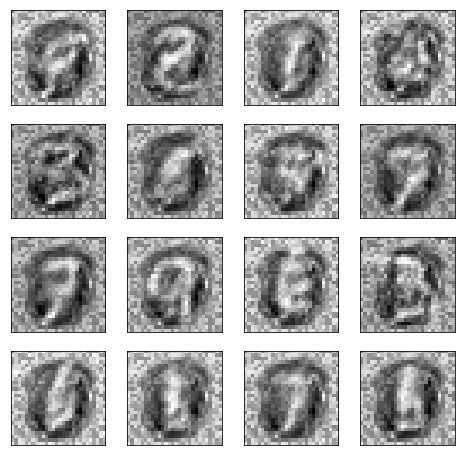

-------------------------------------------------------------------
[epoch 88], [training time 8.82]
-------------------------------------------------------------------


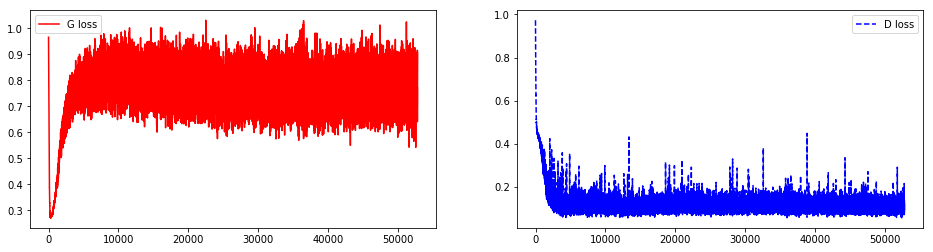

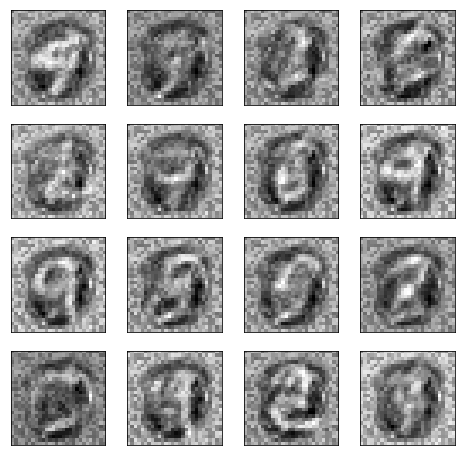

-------------------------------------------------------------------
[epoch 89], [training time 8.81]
-------------------------------------------------------------------


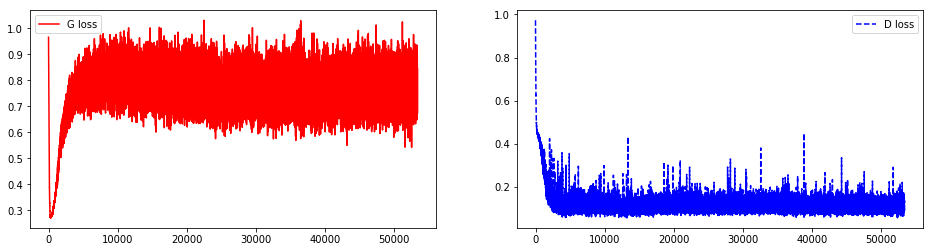

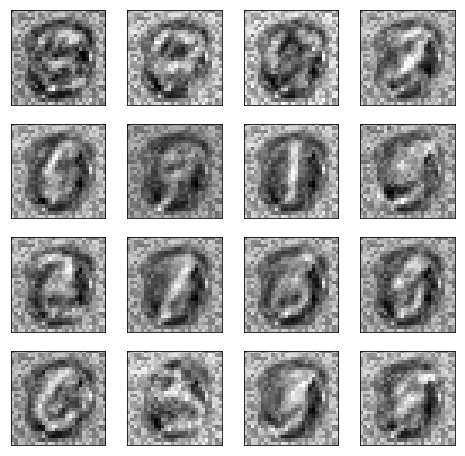

-------------------------------------------------------------------
[epoch 90], [training time 8.82]
-------------------------------------------------------------------


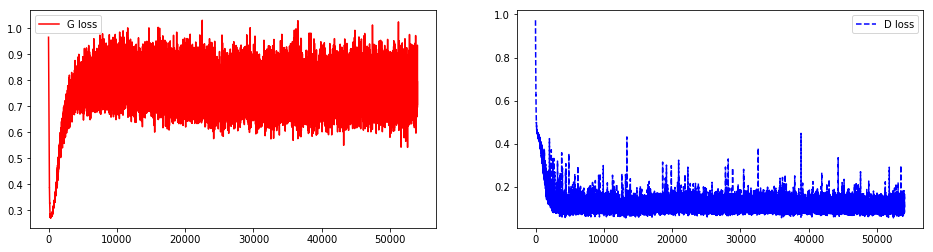

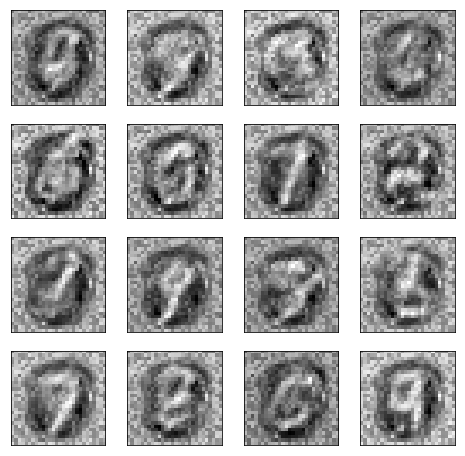

-------------------------------------------------------------------
[epoch 91], [training time 8.86]
-------------------------------------------------------------------


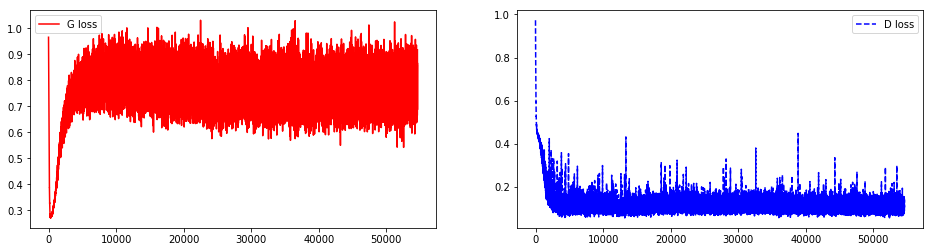

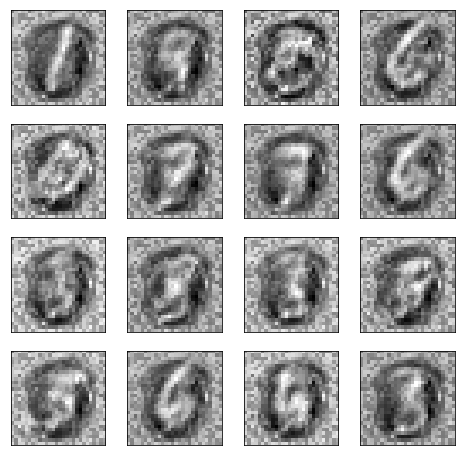

-------------------------------------------------------------------
[epoch 92], [training time 8.82]
-------------------------------------------------------------------


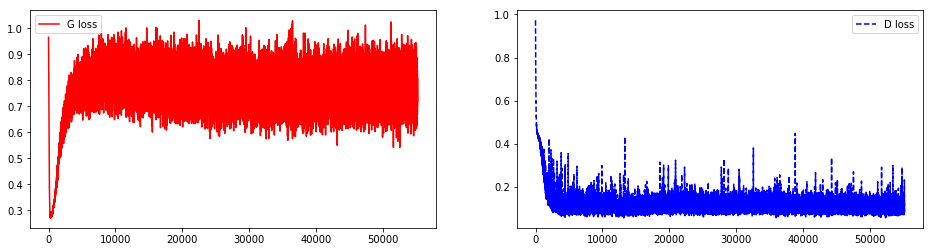

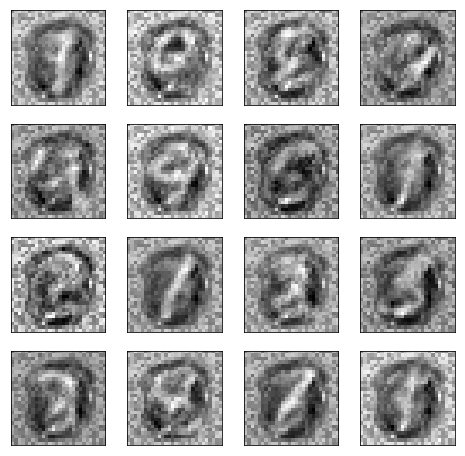

-------------------------------------------------------------------
[epoch 93], [training time 8.80]
-------------------------------------------------------------------


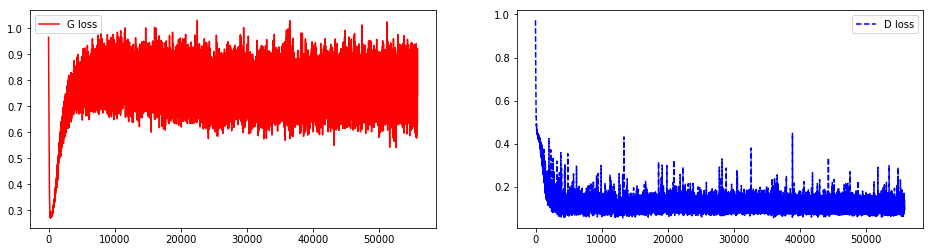

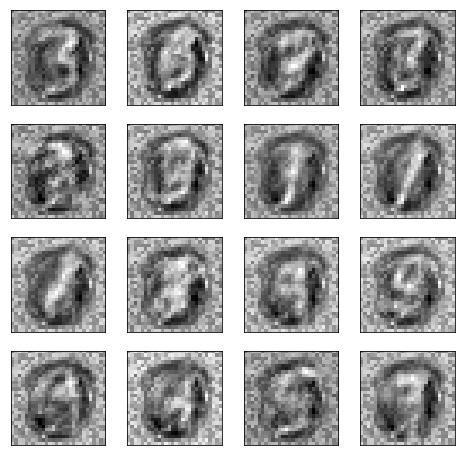

-------------------------------------------------------------------
[epoch 94], [training time 8.88]
-------------------------------------------------------------------


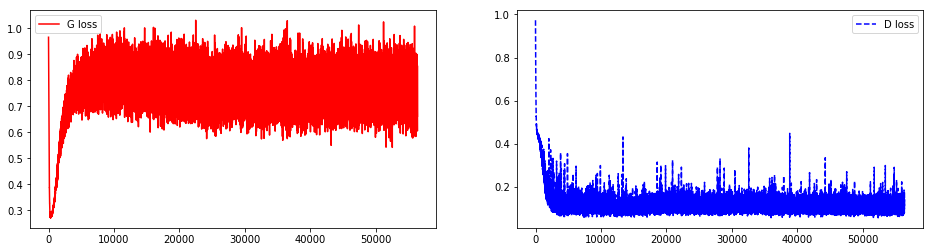

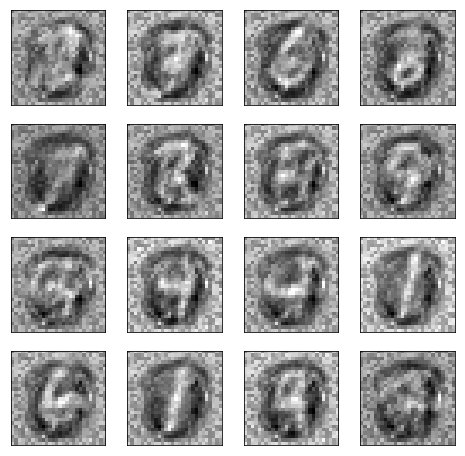

-------------------------------------------------------------------
[epoch 95], [training time 9.92]
-------------------------------------------------------------------


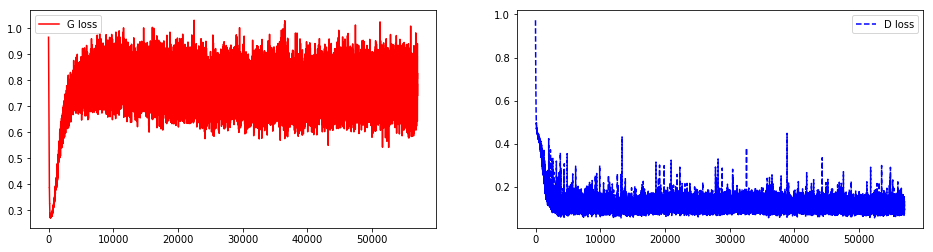

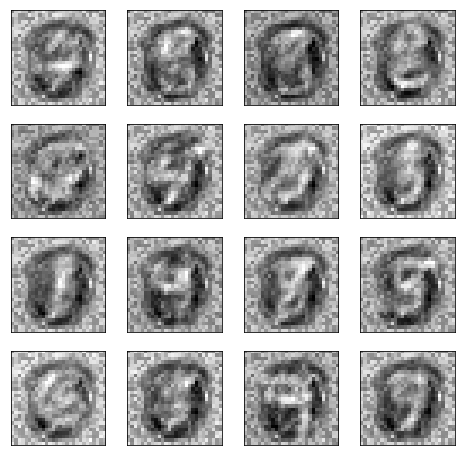

-------------------------------------------------------------------
[epoch 96], [training time 8.81]
-------------------------------------------------------------------


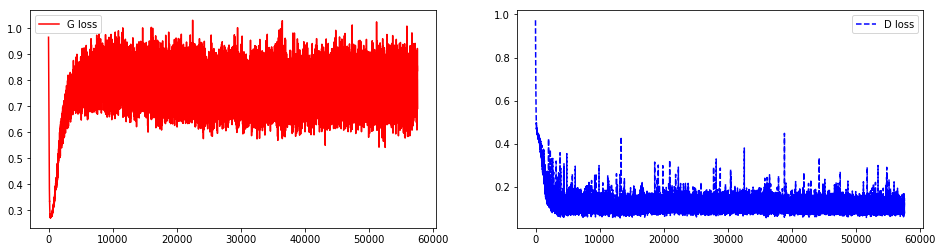

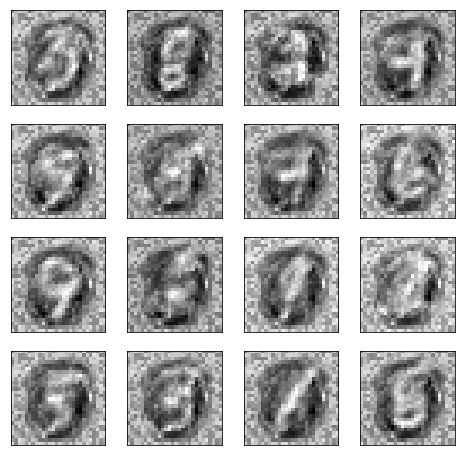

-------------------------------------------------------------------
[epoch 97], [training time 8.83]
-------------------------------------------------------------------


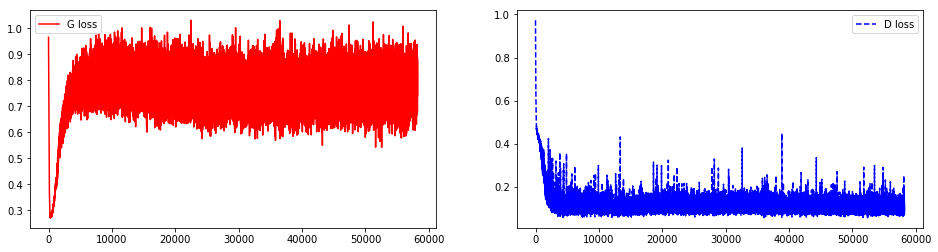

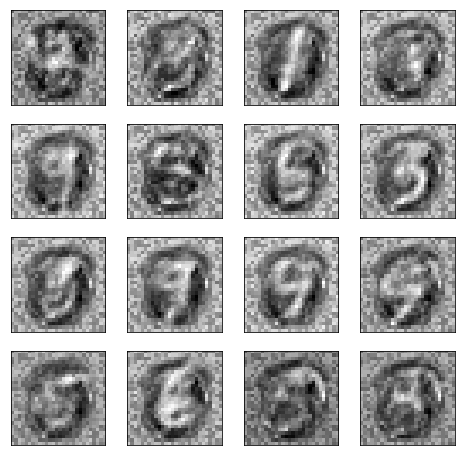

-------------------------------------------------------------------
[epoch 98], [training time 8.79]
-------------------------------------------------------------------


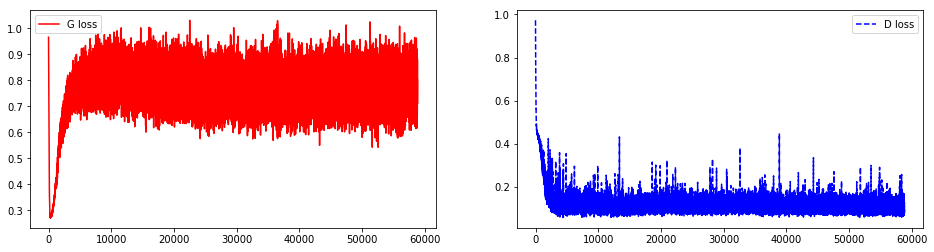

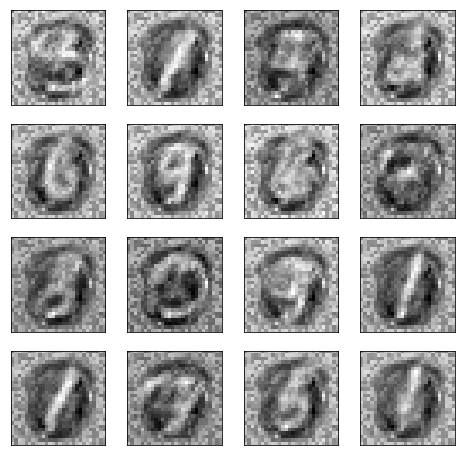

-------------------------------------------------------------------
[epoch 99], [training time 8.82]
-------------------------------------------------------------------


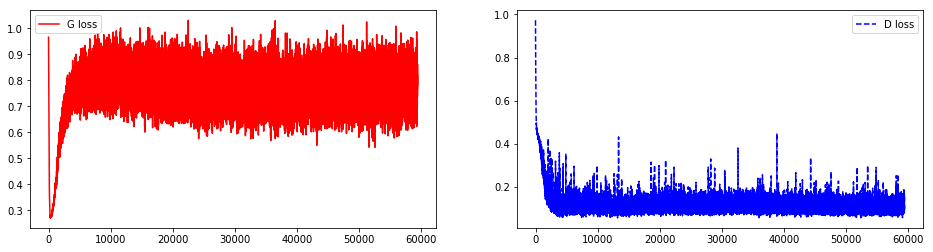

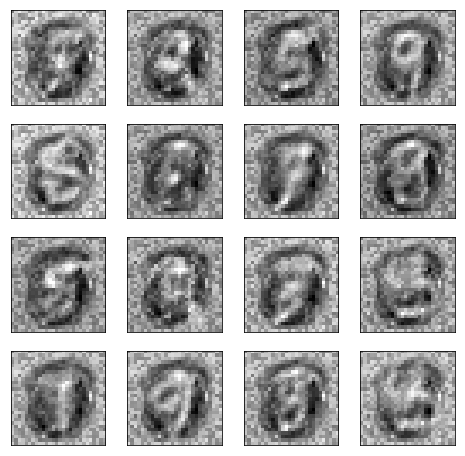

-------------------------------------------------------------------
[epoch 100], [training time 9.01]
-------------------------------------------------------------------


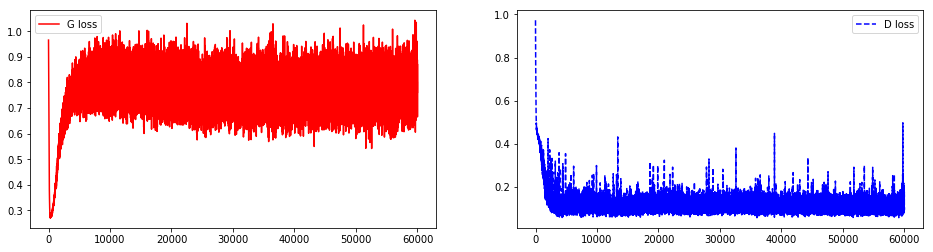

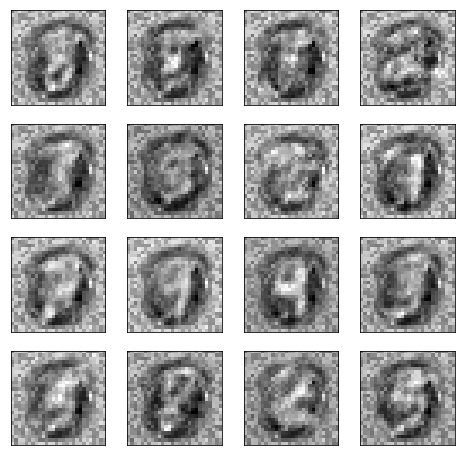

In [11]:
# Lists for losses.
train_loss_G = []
train_loss_D = []

# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train_loss_G, train_loss_D = train(train_loader,
                                       net_G, net_D,
                                       criterion,
                                       opt_G, opt_D,
                                       epoch,
                                       train_loss_G, train_loss_D)
    
    # Taking step on scheduler.
    scheduler_G.step()
    scheduler_D.step()

    if epoch % args['print_freq'] == 0:
        
        # Testing function for sample generation.
        evaluate(net_G, criterion, epoch)